In [1]:
import pandas as pd
import numpy as np


#For text cleaning the product descriptions
import string
import spacy
nlp = spacy.load('en_core_web_sm')

# Word tokenization
from spacy.lang.en import English

#For processing dates
from datetime import datetime
from datetime import timedelta

#Time Series Models
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric


#SKLearn Error Metrics
from sklearn.metrics import mean_absolute_error

#Visualize results
import matplotlib.pyplot as plt


In [2]:
prod_order201419 = pd.read_pickle('prod_order201419.pkl')
fb_df = pd.read_pickle('fb_df.pkl')

# Baseline Comparison of Naive vs. Prophet Model

First, using TIME SERIES train-test split (fixed training period)

In [3]:
fb_df['y'] = np.log1p(fb_df['y'])

In [4]:
fb_df['ds']

0      2014-10-19
1      2014-10-20
2      2014-10-21
3      2014-10-22
4      2014-10-23
          ...    
1835   2019-10-28
1836   2019-10-29
1837   2019-10-30
1838   2019-10-31
1839   2019-11-01
Name: ds, Length: 1840, dtype: datetime64[ns]

In [5]:
#Removing outlier dates (10/19/14, 10/31/14, 11/1/14) from the dataframe because their presence produced ZERO counts in between these dates and our first file's date of 11/3/14. 
fb_df = fb_df[fb_df['ds'] >= pd.to_datetime('2014-11-03')]

In [6]:
fb_df.index = fb_df.index - 15

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [7]:
fb_df

,y,ds
0,1.609438,2014-11-03
1,0.693147,2014-11-04
2,1.945910,2014-11-05
3,1.609438,2014-11-06
4,2.197225,2014-11-07
...,...,...
1820,1.386294,2019-10-28
1821,1.386294,2019-10-29
1822,1.945910,2019-10-30
1823,1.945910,2019-10-31


In [8]:
from sklearn.model_selection import TimeSeriesSplit

X = fb_df['ds']
y = fb_df['y']
tscv = TimeSeriesSplit(max_train_size=int(len(fb_df['y'])*0.8), n_splits=5)

X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
    X_train = pd.Series(X[train_index])
    X_test = pd.Series(X[test_index])
    y_train = pd.Series(y[train_index])
    y_test = pd.Series(y[test_index])
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)
    
    

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [9]:
X_train_list[1]

0     2014-11-03
1     2014-11-04
2     2014-11-05
3     2014-11-06
4     2014-11-07
         ...    
604   2016-06-29
605   2016-06-30
606   2016-07-01
607   2016-07-02
608   2016-07-03
Name: ds, Length: 609, dtype: datetime64[ns]

In [10]:
forecast_cv_list = []

for X_train, y_test in zip(X_train_list, y_test_list):
    fb_df_train = X_train.to_frame().join(y_train.to_frame())
    m = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,growth='linear')
    m.fit(fb_df_train)

    future = m.make_future_dataframe(periods=len(y_test),include_history=False)
    forecast = m.predict(future)
    forecast_cv_list.append(forecast)
   
# def show_forecasts(forecast_list):
#     for forecast in forecast_list:
#         print(forecast.tail())
    
# show_forecasts(forecast_cv_list)

forecast_cv_list


[            ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
 0   2015-09-04  2.007384    1.433439    3.058585     2.007384     2.007384   
 1   2015-09-05  2.006361    1.159018    2.837260     2.006361     2.006361   
 2   2015-09-06  2.005339   -0.354630    1.217373     2.005339     2.005339   
 3   2015-09-07  2.004316    0.820638    2.436693     2.004316     2.004316   
 4   2015-09-08  2.003294    0.805467    2.504374     2.003294     2.003294   
 ..         ...       ...         ...         ...          ...          ...   
 299 2016-06-29  1.701633    0.803177    2.407599     1.701633     1.701634   
 300 2016-06-30  1.700610    1.106500    2.700419     1.700610     1.700611   
 301 2016-07-01  1.699588    1.326198    2.971597     1.699587     1.699588   
 302 2016-07-02  1.698565    1.173498    2.851760     1.698565     1.698566   
 303 2016-07-03  1.697543   -0.427386    1.246478     1.697542     1.697543   
 
      additive_terms  additive_terms_lower  additi

**Results: Prophet**

In [11]:
mae_list = []
for y_test, forecast in zip(y_test_list, forecast_cv_list):
    expected = y_test.tolist()
#expected_adjusted = np.exp(expected)-0.01
    predictions = forecast.yhat.tolist()
#predictions_adjusted = np.exp(predictions)-0.01
    mae = np.expm1(mean_absolute_error(expected,predictions))
    #mae = mean_absolute_error(expected_adjusted,predictions_adjusted)
    mae_list.append(mae)
print(mae_list)

[0.902043920783328, 0.6262079801062461, 0.6106639400342927, 0.5458345880883124, 0.5488450335779947]


In [12]:
forecast_cv_list[0]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-09-04,2.007384,1.433439,3.058585,2.007384,2.007384,0.208556,0.208556,0.208556,-0.179546,...,0.526697,0.526697,0.526697,-0.138596,-0.138596,-0.138596,0.0,0.0,0.0,2.215940
1,2015-09-05,2.006361,1.159018,2.837260,2.006361,2.006361,0.006284,0.006284,0.006284,-0.179546,...,0.351824,0.351824,0.351824,-0.165994,-0.165994,-0.165994,0.0,0.0,0.0,2.012645
2,2015-09-06,2.005339,-0.354630,1.217373,2.005339,2.005339,-1.598845,-1.598845,-1.598845,-0.179546,...,-1.231502,-1.231502,-1.231502,-0.187798,-0.187798,-0.187798,0.0,0.0,0.0,0.406494
3,2015-09-07,2.004316,0.820638,2.436693,2.004316,2.004316,-0.378240,-0.378240,-0.378240,-0.179546,...,0.004827,0.004827,0.004827,-0.203521,-0.203521,-0.203521,0.0,0.0,0.0,1.626077
4,2015-09-08,2.003294,0.805467,2.504374,2.003294,2.003294,-0.337843,-0.337843,-0.337843,-0.179546,...,0.054566,0.054566,0.054566,-0.212864,-0.212864,-0.212864,0.0,0.0,0.0,1.665451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,2016-06-29,1.701633,0.803177,2.407599,1.701633,1.701634,-0.072218,-0.072218,-0.072218,-0.179546,...,0.016419,0.016419,0.016419,0.090910,0.090910,0.090910,0.0,0.0,0.0,1.629415
300,2016-06-30,1.700610,1.106500,2.700419,1.700610,1.700611,0.204323,0.204323,0.204323,-0.179546,...,0.277168,0.277168,0.277168,0.106700,0.106700,0.106700,0.0,0.0,0.0,1.904933
301,2016-07-01,1.699588,1.326198,2.971597,1.699587,1.699588,0.468371,0.468371,0.468371,-0.179546,...,0.526697,0.526697,0.526697,0.121219,0.121219,0.121219,0.0,0.0,0.0,2.167958
302,2016-07-02,1.698565,1.173498,2.851760,1.698565,1.698566,0.305748,0.305748,0.305748,-0.179546,...,0.351824,0.351824,0.351824,0.133470,0.133470,0.133470,0.0,0.0,0.0,2.004314


**Results: Naive Model (predict previous days' order count)**

In [13]:
naive_cv_list = []

for y_train, y_test in zip(y_train_list, y_test_list):
    Naive_y_test = y_test.copy()
    naive_predictions = Naive_y_test.to_frame().shift(1)
    #naive_predictions.set_value(Naive_y_test.idxmin(), 'y', float(y_train.iloc[-1])) --didn't always work b/c some remained NaN
    naive_predictions.fillna(float(y_train.iloc[-1]),inplace=True) 
    naive_cv_list.append(naive_predictions)

print(naive_cv_list)

[            y
305  2.079442
306  1.945910
307  0.000000
308  1.098612
309  0.000000
..        ...
604  2.397895
605  1.791759
606  2.833213
607  2.079442
608  2.708050

[304 rows x 1 columns],             y
609  0.000000
610  0.000000
611  1.791759
612  2.639057
613  2.484907
..        ...
908  2.484907
909  2.995732
910  0.000000
911  1.791759
912  1.386294

[304 rows x 1 columns],              y
913   2.397895
914   2.197225
915   2.639057
916   2.833213
917   0.693147
...        ...
1212  2.564949
1213  2.302585
1214  2.944439
1215  2.772589
1216  2.833213

[304 rows x 1 columns],              y
1217  2.708050
1218  1.609438
1219  2.197225
1220  2.397895
1221  2.079442
...        ...
1516  2.079442
1517  1.791759
1518  2.484907
1519  1.098612
1520  3.367296

[304 rows x 1 columns],              y
1521  0.000000
1522  0.000000
1523  0.000000
1524  1.609438
1525  1.945910
...        ...
1820  0.000000
1821  1.386294
1822  1.386294
1823  1.945910
1824  1.945910

[304 rows x 1 columns]

In [14]:
naive_mae_list = []
for y_test, naive_y in zip(y_test_list, naive_cv_list):
    expected = y_test.tolist()
#expected_adjusted = np.exp(expected)-0.01
    predictions = naive_y.y.tolist()
#predictions_adjusted = np.exp(predictions)-0.01
    naive_mae = np.expm1(mean_absolute_error(expected,predictions))
    #mae = mean_absolute_error(expected_adjusted,predictions_adjusted)
    naive_mae_list.append(naive_mae)
print(naive_mae_list)

[1.1996632951946946, 1.3719723128720354, 1.320727742239239, 1.0624944346295007, 1.0740264459920903]


In [15]:
naive_y.y.tolist()

[0.0,
 0.0,
 0.0,
 1.6094379124341003,
 1.9459101490553132,
 1.791759469228055,
 2.0794415416798357,
 2.1972245773362196,
 2.1972245773362196,
 1.791759469228055,
 2.772588722239781,
 1.6094379124341003,
 2.5649493574615367,
 1.0986122886681098,
 2.1972245773362196,
 1.6094379124341003,
 1.791759469228055,
 2.5649493574615367,
 1.791759469228055,
 1.3862943611198906,
 0.0,
 1.791759469228055,
 1.6094379124341003,
 2.0794415416798357,
 2.302585092994046,
 2.8903717578961645,
 0.6931471805599453,
 1.9459101490553132,
 2.1972245773362196,
 2.4849066497880004,
 2.3978952727983707,
 2.3978952727983707,
 2.4849066497880004,
 0.6931471805599453,
 1.9459101490553132,
 1.9459101490553132,
 1.3862943611198906,
 2.302585092994046,
 2.6390573296152584,
 2.0794415416798357,
 1.3862943611198906,
 2.3978952727983707,
 2.3978952727983707,
 3.5263605246161616,
 5.117993812416755,
 1.6094379124341003,
 1.6094379124341003,
 2.302585092994046,
 0.6931471805599453,
 1.791759469228055,
 2.3978952727983707,


In [16]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(((y_true+1) - (y_pred+1)) / (y_true+1))) * 100

In [17]:
# mean_absolute_percentage_error(y_test.tolist(), forecast.yhat.tolist())
len(forecast.yhat.tolist())

304

**Prophet is doing better than naive in 4 out of the 5 folds.**

Prophet results copied from above: [7.102752794130336, 4.911662725046007, 4.70312147261264, 3.9443604498148317, 4.672271462529329]

**Visual Comparison of Results**

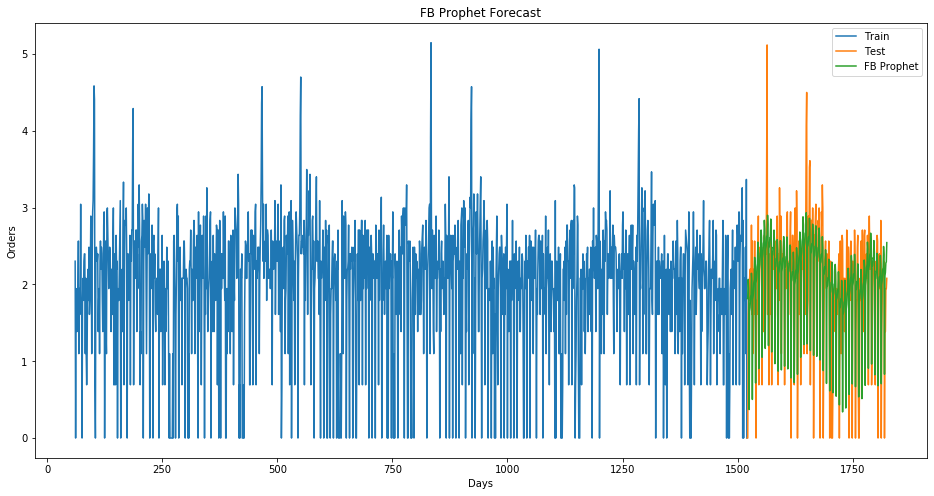

MAE: 0.548845


In [18]:
#most recent train-test fold: 
plt.figure(figsize=(16,8))
plt.plot(fb_df_train['y'], label='Train')
plt.plot(y_test, label='Test')
forecast_cv_list[4]['yhat'].index = forecast_cv_list[4]['yhat'].index + 1521
plt.plot(forecast_cv_list[4]['yhat'], label='FB Prophet')
plt.legend(loc='best')
plt.ylabel('Orders')
plt.xlabel('Days')
plt.title('FB Prophet Forecast')
plt.show()
print('MAE: %f' % mae_list[4])

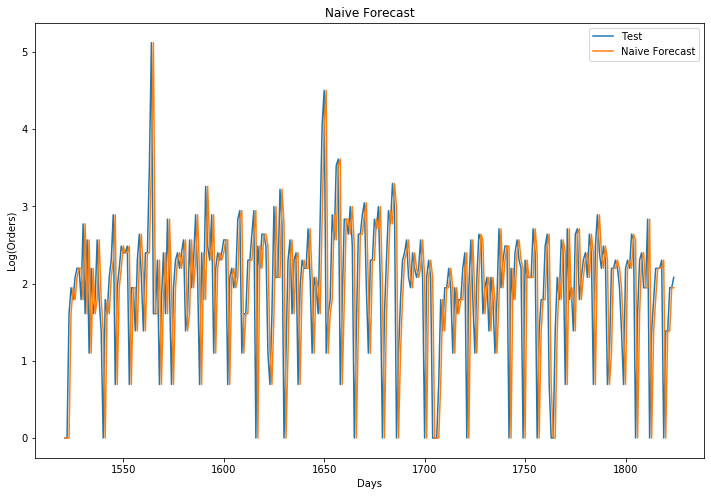

MAE: 1.074026


In [19]:
#most recent train-test fold: 
plt.figure(figsize=(12,8))
#plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(naive_cv_list[4]['y'], label='Naive Forecast')
plt.legend(loc='best')
plt.ylabel('Log(Orders)')
plt.xlabel('Days')
plt.title("Naive Forecast")
plt.show()
print('MAE: %f' % naive_mae_list[4])

With a median daily order count of 2. 2, an MAE of 4 is very poor performance. 

In [20]:
fb_df['y'].median()

2.1972245773362196

I can tune holidays in Facebook Prophet and see how that performs.

In [21]:
Valentines = pd.DataFrame({
  'holiday': 'Valentines',
  'ds': pd.to_datetime(['2015-02-13','2015-02-14', '2016-02-12','2016-02-13','2016-02-14', '2017-02-13','2017-02-14', '2018-02-13','2018-02-14',
                        '2019-02-13','2019-02-14'])})
MothersDay = pd.DataFrame({
  'holiday': 'MothersDay',
  'ds': pd.to_datetime(['2015-05-08','2015-05-09','2015-05-10', '2016-05-06','2016-05-07','2016-05-08', '2017-05-12','2017-05-13', '2018-05-11','2018-05-12',
                        '2018-05-13','2019-05-10','2019-05-11','2019-05-12'])})
# (harder to find historical graduation dates for each school) Graduations = pd.DataFrame({
#   'holiday': 'Graduations',
#   'ds': pd.to_datetime(['',''])})

holidays = pd.concat((Valentines, MothersDay))

In [22]:
forecast_holidays_cv_list = []

for X_train, y_test in zip(X_train_list, y_test_list):
    fb_df_train = X_train.to_frame().join(y_train.to_frame())
    m_holidays = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,growth='linear',holidays=holidays)
    m_holidays.fit(fb_df_train)

    future_holidays = m_holidays.make_future_dataframe(periods=len(y_test),include_history=False)
    forecast_holidays = m_holidays.predict(future_holidays)
    forecast_holidays_cv_list.append(forecast_holidays)

forecast_holidays_cv_list

[            ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
 0   2015-09-04  2.037474    1.342431    2.848420     2.037474     2.037474   
 1   2015-09-05  2.036628    1.062700    2.656315     2.036628     2.036628   
 2   2015-09-06  2.035781   -0.493719    1.142833     2.035781     2.035781   
 3   2015-09-07  2.034935    0.805209    2.371808     2.034935     2.034935   
 4   2015-09-08  2.034089    0.814670    2.462687     2.034089     2.034089   
 ..         ...       ...         ...         ...          ...          ...   
 299 2016-06-29  1.784450    0.956699    2.539623     1.784450     1.784451   
 300 2016-06-30  1.783604    1.240434    2.808553     1.783603     1.783605   
 301 2016-07-01  1.782758    1.410546    2.943237     1.782757     1.782759   
 302 2016-07-02  1.781912    1.309461    2.765468     1.781911     1.781912   
 303 2016-07-03  1.781065   -0.255640    1.309459     1.781065     1.781066   
 
      MothersDay  MothersDay_lower  MothersDay_upp

In [23]:
mae_holidays_list = []
for y_test, forecast in zip(y_test_list, forecast_holidays_cv_list):
    expected = y_test.tolist()
#expected_adjusted = np.exp(expected)-0.01
    predictions = forecast_holidays.yhat.tolist()
#predictions_adjusted = np.exp(predictions)-0.01
    mae_holidays = np.expm1(mean_absolute_error(expected,predictions))
    #mae = mean_absolute_error(expected_adjusted,predictions_adjusted)
    mae_holidays_list.append(mae_holidays)
print(mae_holidays_list)

[1.3168524618569393, 1.3568043590441516, 1.1683449618013126, 1.167344394201659, 0.5161987055743833]


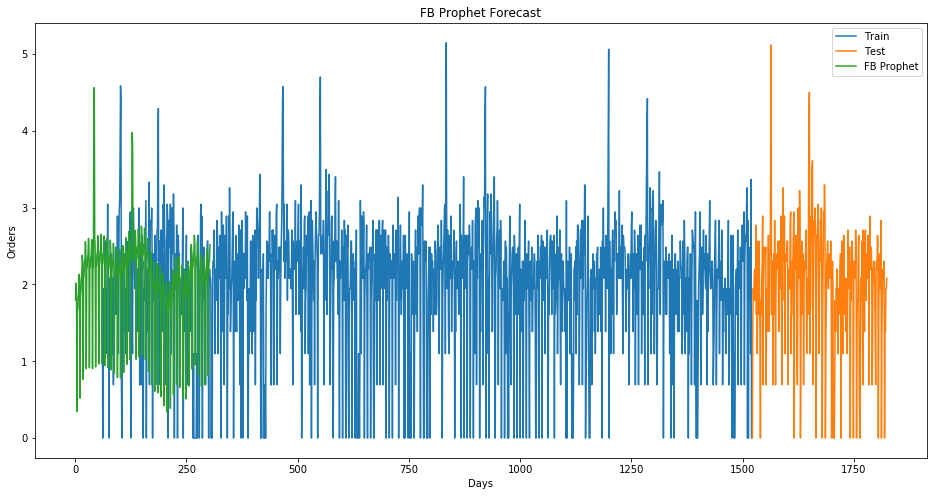

MAE: 0.516199


In [24]:
#most recent train-test fold: 
plt.figure(figsize=(16,8))
plt.plot(fb_df_train['y'], label='Train')
plt.plot(y_test, label='Test')
#forecast_holidays_cv_list[4]['yhat'].index = forecast_holidays_cv_list[4]['yhat'].index + 1521
plt.plot(forecast_holidays_cv_list[4]['yhat'], label='FB Prophet')
plt.legend(loc='best')
plt.ylabel('Orders')
plt.xlabel('Days')
plt.title('FB Prophet Forecast')
plt.show()
print('MAE: %f' % mae_holidays_list[4])

Prophet with holidays fit a lot better on the last fold... Not quite sure why the first 4 folds did not peak with the holidays.

Prophet results copied from above: [7.102752794130336, 4.911662725046007, 4.70312147261264, 3.9443604498148317, 4.672271462529329]


**Plot residuals**

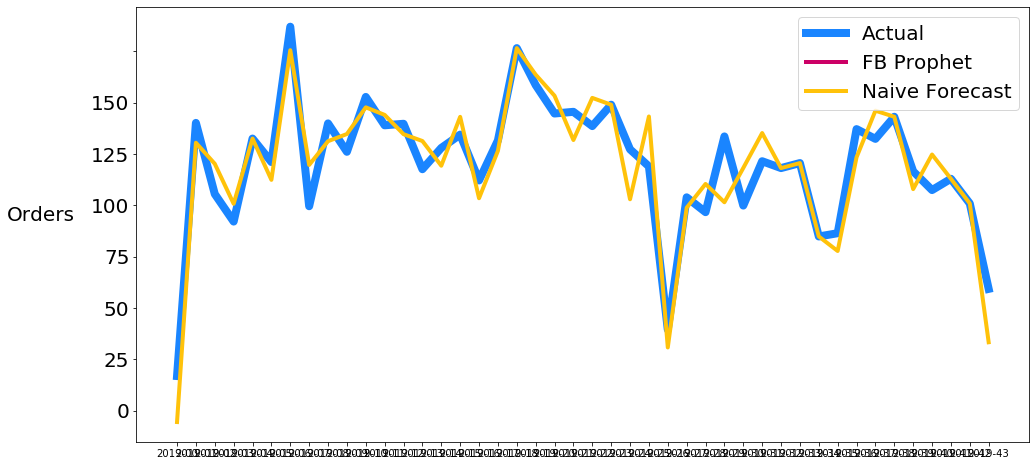

In [141]:
test_list_4 = pd.concat([X_test_list[4],y_test_list[4]], axis=1)
test_list_4_grouped = test_list_4.groupby(test_list_4['ds'].dt.strftime('%Y-%W'))['y'].sum()

forecast_holidays_cv_list_grouped = forecast_holidays_cv_list[4].groupby(forecast_holidays_cv_list[4]['ds'].dt.strftime('%Y-%W'))['yhat'].sum()

naive_test_list_4 = pd.concat([X_test_list[4],naive_cv_list[4]], axis=1)
naive_cv_list_grouped = naive_test_list_4.groupby(naive_test_list_4['ds'].dt.strftime('%Y-%W'))['y'].sum()

customfont = {'fontname':'Open Sans'}

fig, ax = plt.subplots(figsize=(16,8))

plt.plot(test_list_4_grouped, label='Actual', color = '#1A85FF',linewidth=8)
plt.plot(forecast_holidays_cv_list_grouped, label='FB Prophet', color='#cc0066',linewidth=4)
plt.plot(naive_cv_list_grouped, label='Naive Forecast', color='#FFC20A',linewidth=4)
plt.legend(loc='best',prop={'family':'Open Sans', 'size':20})

# labels = [item.get_text() for item in ax.get_xticklabels()]

# labels_1 = test_list_4_grouped.iloc[test_list_4_grouped.reset_index().index.min()]
# labels_2 = test_list_4_grouped.iloc[int(round((int((test_list_4_grouped.reset_index().index.max()-test_list_4_grouped.reset_index().index.min())*1/5)+test_list_4_grouped.reset_index().index.min())/5)*5)]
# labels_3 = test_list_4_grouped.iloc[int(round((int((test_list_4_grouped.reset_index().index.max()-test_list_4_grouped.reset_index().index.min())*2/5)+test_list_4_grouped.reset_index().index.min())/5)*5)]
# labels_4 = test_list_4_grouped.iloc[int(round((int((test_list_4_grouped.reset_index().index.max()-test_list_4_grouped.reset_index().index.min())*3/5)+test_list_4_grouped.reset_index().index.min())/5)*5)]
# labels_5 = test_list_4_grouped.iloc[int(round((int((test_list_4_grouped.reset_index().index.max()-test_list_4_grouped.reset_index().index.min())*4/5)+test_list_4_grouped.reset_index().index.min())/5)*5)]
# labels_6 = test_list_4_grouped.iloc[test_list_4_grouped.reset_index().index.max()]
        
    
# labels[1] = datetime.strftime(labels_1.date(), '%m-%d')
# labels[2] = datetime.strftime(labels_2.date(), '%m-%d')
# labels[3] = datetime.strftime(labels_3.date(), '%m-%d')
# labels[4] = datetime.strftime(labels_4.date(), '%m-%d')
# labels[5] = datetime.strftime(labels_5.date(), '%m-%d')
# labels[6] = datetime.strftime(labels_6.date(), '%m-%d')
# ax.set_xticklabels(labels, fontsize =20, **customfont)
# ax.set_xticklabels(fontsize =20, **customfont)

y_labels = [-25, 0, 25, 50, 75, 100, 125, 150]
ax.set_yticklabels(y_labels, fontsize =20, **customfont)


plt.ylabel('Orders', fontsize = 20, rotation = 0, **customfont,labelpad=50)
plt.show()



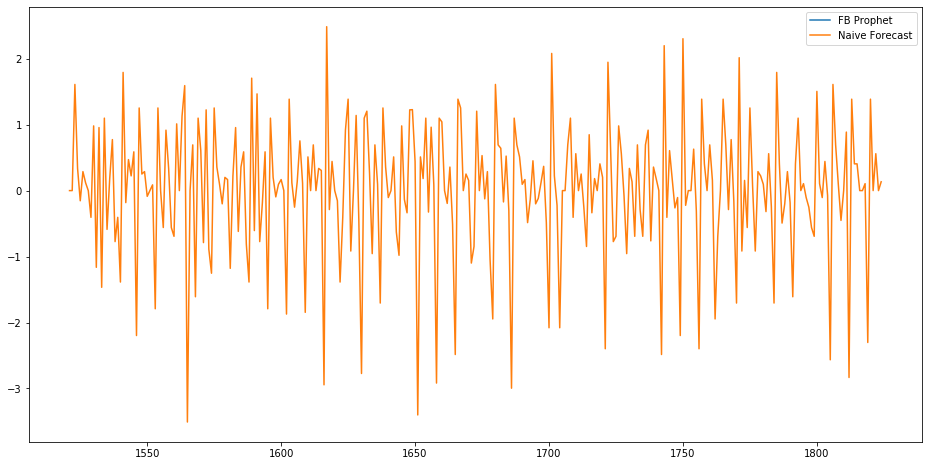

In [26]:
fig = plt.figure(figsize=(16,8))

plt.plot(y_test_list[4].iloc[-365:]-forecast_holidays_cv_list[4]['yhat'].iloc[-365:], label='FB Prophet')
plt.plot(y_test_list[4].iloc[-365:]-naive_cv_list[4]['y'].iloc[-365:], label='Naive Forecast')
plt.legend(loc='best')
#plt.xticks(labels=X_test_list[4].iloc[[1550,1600,1650,1750,1800]].tolist())

In [27]:
X_test_list[4].groupby(X_test_list[4].dt.strftime('%W')).count()
#df.groupby(['name', df['date'].dt.strftime('%W')])['quantity'].sum()


ds
00    5
01    7
02    7
03    7
04    7
05    7
06    7
07    7
08    7
09    7
10    7
11    7
12    7
13    7
14    7
15    7
16    7
17    7
18    7
19    7
20    7
21    7
22    7
23    7
24    7
25    7
26    7
27    7
28    7
29    7
30    7
31    7
32    7
33    7
34    7
35    7
36    7
37    7
38    7
39    7
40    7
41    7
42    7
43    5
Name: ds, dtype: int64

In [28]:
fb_df.groupby(fb_df['ds'].dt.strftime('%Y-%W'))['y'].sum()


ds
2014-44     9.846917
2014-45    10.566382
2014-46    12.460901
2014-47     9.932075
2014-48    10.586584
             ...    
2019-39    13.325076
2019-40    12.594188
2019-41    13.034952
2019-42    12.072313
2019-43     8.743851
Name: y, Length: 265, dtype: float64

In [29]:
test_list_4_grouped.iloc[test_list_4_grouped.reset_index().index.max()]

8.743850562030243

In [30]:
type(test_list_4_grouped.loc[[test_list_4_grouped.reset_index(['ds']).max()]])

KeyError: "None of [Index([('2019-43', 18.961605800491906)], dtype='object', name='ds')] are in the [index]"

In [31]:
# date2 = X_test_list[4].iloc[1]
# datetime.strptime(str(date2), '%Y-%m-%d')
pred_window_max = fb_df['ds'].max()+pd.to_timedelta(7, unit='d')
dt_pred_window_max = datetime.strptime(str(pred_window_max.date()), '%Y-%m-%d')
# fb_df['ds'].max()
dt_pred_window_max

datetime.datetime(2019, 11, 8, 0, 0)

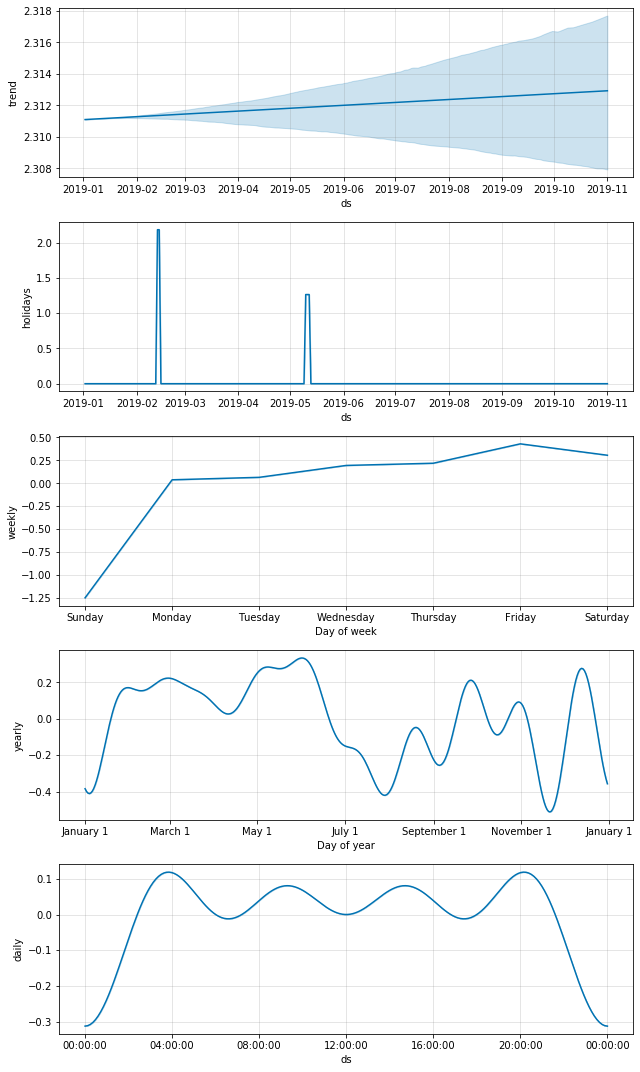

In [32]:
m_holidays.plot_components(forecast);

In [33]:
# for y_test in y_test_list:
#     y_test = np.log1p(y_test)
#     print(y_test)

In [34]:
print(y_test_list[4].mean())
print(y_test_list[4].median())
print(len(y_test_list[4]))

1.9710333048613573
2.0794415416798357
304


**Prophet can struggle with predicting far into the future, and so far we have looked only at results where the training window was fixed and predicting up to 304 days into the future.**

Instead, we can do a rolling window of X_train values and see how these models perform. 

In [35]:
fb_df['rolling_yhat'] = 0
rolling_yhat = []

#Test/Prediction period starting from index/iloc = 305 to be able to compare results for same train size (305 days) to the train-test cv sizes from before
for index, row in fb_df.iloc[305:].iterrows():

    train_model = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,growth='linear')
    train_model.fit(fb_df.iloc[index-305:index])
    future = train_model.make_future_dataframe(periods=1,include_history=False)
    forecast = train_model.predict(future)
    predictions = forecast.yhat
    rolling_yhat.append(predictions)
fb_df['rolling_yhat'].iloc[305:] = rolling_yhat

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
fb_df

,y,ds,rolling_yhat
0,1.609438,2014-11-03,0.000000
1,0.693147,2014-11-04,0.000000
2,1.945910,2014-11-05,0.000000
3,1.609438,2014-11-06,0.000000
4,2.197225,2014-11-07,0.000000
...,...,...,...
1820,1.386294,2019-10-28,1.357497
1821,1.386294,2019-10-29,1.803935
1822,1.945910,2019-10-30,1.711378
1823,1.945910,2019-10-31,1.788470


In [37]:
rolling_expected = fb_df.y.iloc[305:].tolist()
rolling_predictions = fb_df.rolling_yhat.iloc[305:].tolist()
mae_rolling = np.expm1(mean_absolute_error(rolling_expected, rolling_predictions))
mae_rolling 

0.6931493552452126

In [38]:
rolling_expected_ytest_cv1 = fb_df.y.iloc[305:609].tolist()
rolling_predictions_ytest_cv1 = fb_df.rolling_yhat.iloc[305:609].tolist()
mae_rolling_ytest_cv1 = np.expm1(mean_absolute_error(rolling_expected_ytest_cv1, rolling_predictions_ytest_cv1))
mae_rolling_ytest_cv1 

0.7813208387997296

In [39]:
rolling_expected_ytest_cv2 = fb_df.y.iloc[609:913].tolist()
rolling_predictions_ytest_cv2 = fb_df.rolling_yhat.iloc[609:913].tolist()
mae_rolling_ytest_cv2 = np.expm1(mean_absolute_error(rolling_expected_ytest_cv2, rolling_predictions_ytest_cv2))
mae_rolling_ytest_cv2 

0.710378491975523

In [40]:
rolling_expected_ytest_cv3 = fb_df.y.iloc[913:1217].tolist()
rolling_predictions_ytest_cv3 = fb_df.rolling_yhat.iloc[913:1217].tolist()
mae_rolling_ytest_cv3 = np.expm1(mean_absolute_error(rolling_expected_ytest_cv3, rolling_predictions_ytest_cv3))
mae_rolling_ytest_cv3 

0.7093442083464957

In [41]:
rolling_expected_ytest_cv4 = fb_df.y.iloc[1217:1521].tolist()
rolling_predictions_ytest_cv4 = fb_df.rolling_yhat.iloc[1217:1521].tolist()
mae_rolling_ytest_cv4 = np.expm1(mean_absolute_error(rolling_expected_ytest_cv4, rolling_predictions_ytest_cv4))
mae_rolling_ytest_cv4 

0.5977605189675059

In [42]:
rolling_expected_ytest_cv5 = fb_df.y.iloc[1521:].tolist()
rolling_predictions_ytest_cv5 = fb_df.rolling_yhat.iloc[1521:].tolist()
mae_rolling_ytest_cv5 = np.expm1(mean_absolute_error(rolling_expected_ytest_cv5, rolling_predictions_ytest_cv5))
mae_rolling_ytest_cv5 

0.6722482972072837

In [44]:
fb_df.iloc[305:609]

,y,ds,rolling_yhat
305,1.945910,2015-09-04,1.870008
306,0.000000,2015-09-05,1.818786
307,1.098612,2015-09-06,-0.345078
308,0.000000,2015-09-07,1.346675
309,2.197225,2015-09-08,0.777668
...,...,...,...
604,1.791759,2016-06-29,2.159667
605,2.833213,2016-06-30,2.163384
606,2.079442,2016-07-01,2.511022
607,2.708050,2016-07-02,2.136936


In [45]:
y_test_list[0]

305    1.945910
306    0.000000
307    1.098612
308    0.000000
309    2.197225
         ...   
604    1.791759
605    2.833213
606    2.079442
607    2.708050
608    0.000000
Name: y, Length: 304, dtype: float64

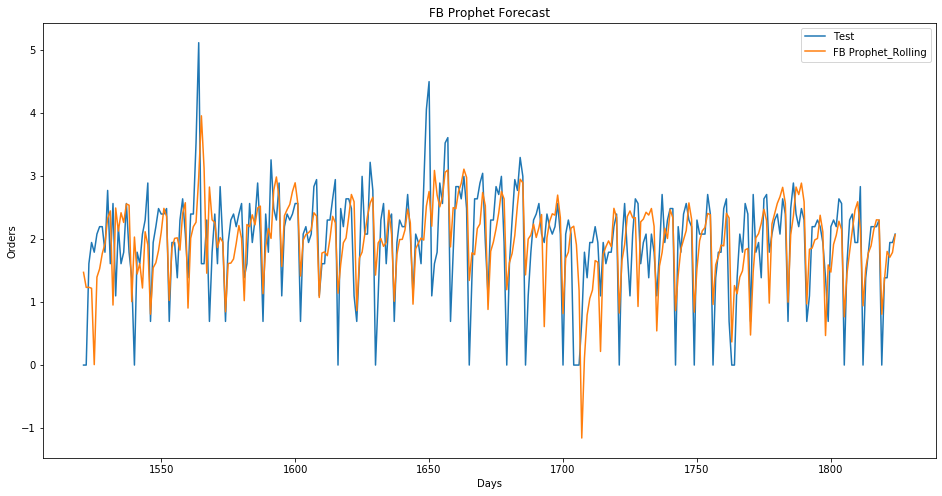

MAE: 0.672248


In [46]:
plt.figure(figsize=(16,8))
plt.plot(fb_df['y'].iloc[1521:], label='Test')
plt.plot(fb_df['rolling_yhat'].iloc[1521:], label='FB Prophet_Rolling')
plt.legend(loc='best')
plt.ylabel('Orders')
plt.xlabel('Days')
plt.title('FB Prophet Forecast')
plt.show()
print('MAE: %f' % mae_rolling_ytest_cv5)

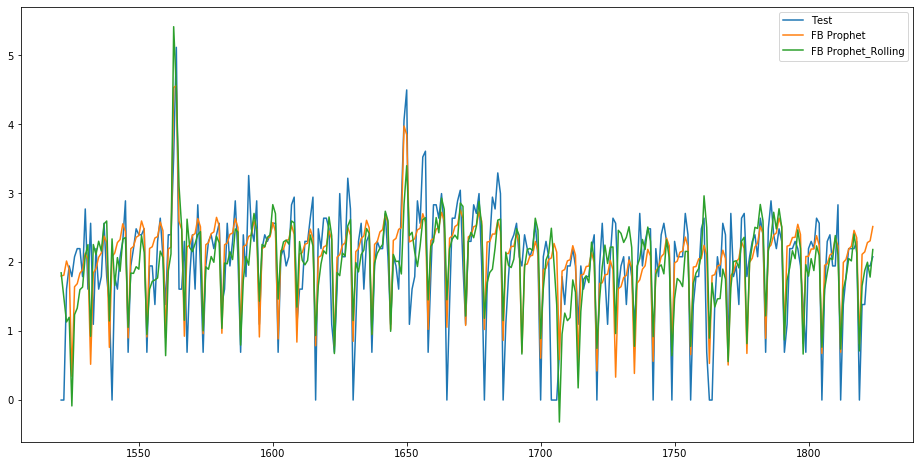

In [74]:
plt.figure(figsize=(16,8))

forecast_holidays_cv_list[4].index = forecast_holidays_cv_list[4].index+1521 
plt.plot(fb_df['y'].iloc[1521:], label='Test')
plt.plot(forecast_holidays_cv_list[4]['yhat'], label='FB Prophet')
plt.plot(fb_df['rolling_yhat'].iloc[1521:], label='FB Prophet_Rolling')
plt.legend(loc='best')

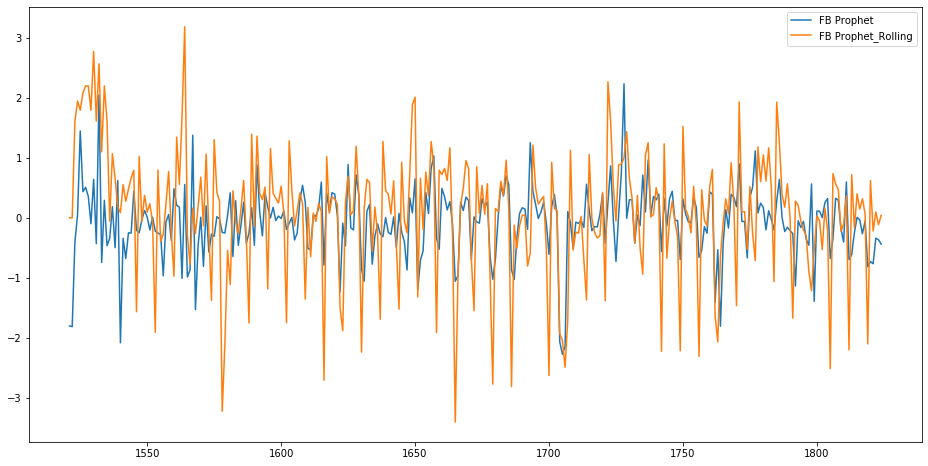

In [149]:
plt.figure(figsize=(16,8))
#forecast_holidays_cv_list[4].index = forecast_holidays_cv_list[4].index+1521 
plt.plot(y_test_list[4]-forecast_holidays_cv_list[4]['yhat'], label='FB Prophet')
plt.plot(y_test_list[4]-fb_df['rolling_yhat'].iloc[1521:], label='FB Prophet_Rolling')
plt.legend(loc='best')

In [49]:
index = 305
len(fb_df.iloc[index-305:index])
fb_df.iloc[:305]

,y,ds,rolling_yhat
0,1.609438,2014-11-03,0.0
1,0.693147,2014-11-04,0.0
2,1.945910,2014-11-05,0.0
3,1.609438,2014-11-06,0.0
4,2.197225,2014-11-07,0.0
...,...,...,...
300,0.000000,2015-08-30,0.0
301,1.945910,2015-08-31,0.0
302,2.197225,2015-09-01,0.0
303,2.079442,2015-09-02,0.0


In [50]:
len(y_test_list[0])

304

In [51]:
print(len(X_train_list[0]))
print(len(X_train_list[1]))
print(len(X_train_list[2]))
print(len(X_train_list[3]))
print(len(X_train_list[4]))

305
609
913
1217
1460


In [52]:
fb_df['rolling_yhat_holiday_305'] = 0
rolling_yhat_holiday_305 = []

#Test/Prediction period starting from index/iloc = 305 to be able to compare results for same train size (305 days) to the train-test cv sizes from before
for index, row in fb_df.iloc[305:].iterrows():

    train_model_rollingholiday_305 = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,growth='linear', holidays=holidays)
    train_model_rollingholiday_305.fit(fb_df.iloc[index-305:index])
    future_rollingholiday_305 = train_model_rollingholiday_305.make_future_dataframe(periods=1,include_history=False)
    forecast = train_model.predict(future_rollingholiday_305)
    predictions = forecast.yhat
    rolling_yhat_holiday_305.append(predictions)
fb_df['rolling_yhat_holiday_305'].iloc[305:] = rolling_yhat_holiday_305

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
rolling_expected = fb_df.y.iloc[305:].tolist()
rolling_predictions_holiday_305 = fb_df.rolling_yhat_holiday_305.iloc[305:].tolist()
mae_rolling_holiday_305 = np.expm1(mean_absolute_error(rolling_expected, rolling_yhat_holiday_305))
mae_rolling_holiday_305

12.740931390645896

In [54]:
rolling_expected_ytest_cv4 = fb_df.y.iloc[1217:1521].tolist()
rolling_predictions_ytest_holiday_305_cv4 = fb_df.rolling_yhat_holiday_305.iloc[1217:1521].tolist()
mae_rolling_ytest_holiday_305_cv4 = np.expm1(mean_absolute_error(rolling_expected_ytest_cv4, rolling_predictions_ytest_holiday_305_cv4))
mae_rolling_ytest_holiday_305_cv4 

2.9553211377766404

In [55]:
y_test_list[3]

1217    1.609438
1218    2.197225
1219    2.397895
1220    2.079442
1221    2.302585
          ...   
1516    1.791759
1517    2.484907
1518    1.098612
1519    3.367296
1520    0.000000
Name: y, Length: 304, dtype: float64

In [56]:
fb_df['rolling_yhat'] = 0
rolling_yhat = []

#Test/Prediction period starting from index/iloc = 305 to be able to compare results for same train size (305 days) to the train-test cv sizes from before
for index, row in fb_df.iloc[1217:].iterrows():

    train_model_holidays_1217 = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,growth='linear',holidays=holidays)
    train_model_holidays_1217.fit(fb_df.iloc[index-1217:index])
    future_holidays_1217 = train_model_holidays_1217.make_future_dataframe(periods=1,include_history=False)
    forecast_holidays_1217 = train_model_holidays_1217.predict(future_holidays_1217)
    predictions_holidays_1217 = forecast_holidays_1217.yhat
    rolling_yhat.append(predictions_holidays_1217)
fb_df['rolling_yhat'].iloc[1217:] = rolling_yhat

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [57]:
rolling_expected = fb_df.y.iloc[1217:].tolist()
rolling_1217_predictions = fb_df.rolling_yhat.iloc[1217:].tolist()
mae_1217_rolling = np.expm1(mean_absolute_error(rolling_expected, rolling_1217_predictions))
mae_1217_rolling 

0.517802593514611

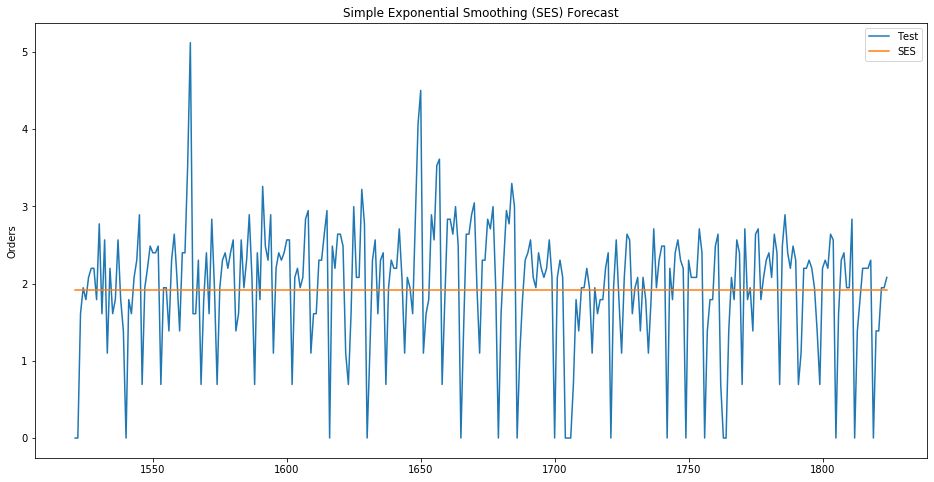

In [63]:
import statsmodels
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
fit = SimpleExpSmoothing(np.asarray(y_train_list[4])).fit()
y_hat_avg = pd.Series(fit.forecast(len(y_test_list[4])))
y_hat_avg.index = y_hat_avg.index+1521
plt.figure(figsize=(16,8))
plt.plot(y_test_list[4], label='Test')
plt.plot(y_hat_avg, label='SES')
plt.legend(loc='best')
plt.ylabel('Orders')
plt.title('Simple Exponential Smoothing (SES) Forecast')
plt.show()

In [64]:
fb_df['SES_rolling_yhat'] = 0
SES_rolling_yhat = []


for index, row in fb_df.iloc[365:].iterrows():
#for i in df.index[89:]:
    SES_train_model = SimpleExpSmoothing(np.asarray(fb_df['y'].iloc[index-365:index])).fit()
    predictions = SES_train_model.forecast(1)
    SES_rolling_yhat.append(predictions)
fb_df['SES_rolling_yhat'].iloc[365:] = SES_rolling_yhat

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/ho

In [65]:
rolling_expected = fb_df.y.iloc[1521:].tolist()
SES_rolling_predictions = fb_df.SES_rolling_yhat.iloc[1521:].tolist()
mae = np.expm1(mean_absolute_error(rolling_expected,SES_rolling_predictions))
mae

0.816379401305518

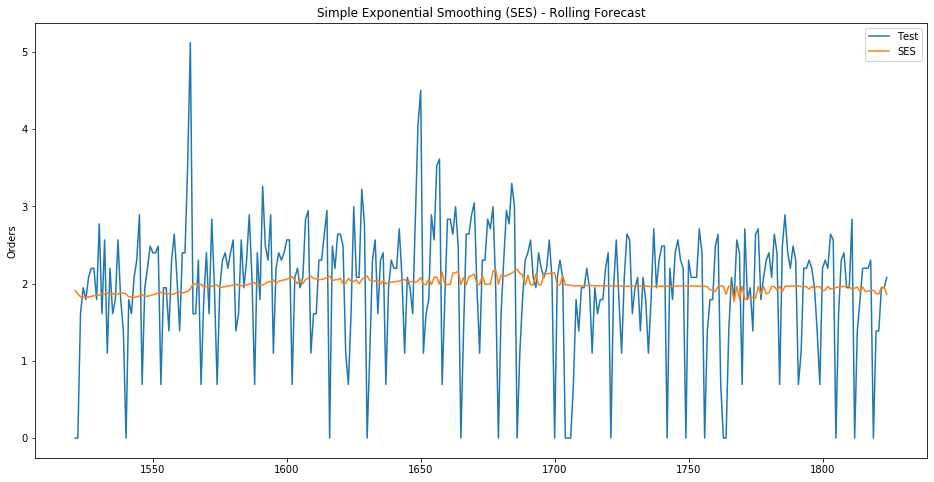

In [66]:
plt.figure(figsize=(16,8))
plt.plot(fb_df.y.iloc[1521:], label='Test')
plt.plot(fb_df.SES_rolling_yhat.iloc[1521:], label='SES')
plt.legend(loc='best')
plt.ylabel('Orders')
plt.title('Simple Exponential Smoothing (SES) - Rolling Forecast')
plt.show()

In [403]:
fb_df['SES_extending_yhat'] = 0
SES_extending_yhat = []


for index, row in fb_df.iloc[365:].iterrows():
#for i in df.index[89:]:
    SES_train_model = SimpleExpSmoothing(np.asarray(fb_df['y'].iloc[:index])).fit()
    predictions = SES_train_model.forecast(1)
    SES_extending_yhat.append(predictions)
fb_df['SES_extending_yhat'].iloc[365:] = SES_extending_yhat

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_gui

In [404]:
fb_df

,ds,y,SES_extending_yhat
0,2014-10-19,0.000000,0.000000
1,2014-10-20,0.000000,0.000000
2,2014-10-21,0.000000,0.000000
3,2014-10-22,0.000000,0.000000
4,2014-10-23,0.000000,0.000000
...,...,...,...
1835,2019-10-28,1.386294,1.823598
1836,2019-10-29,1.386294,1.800654
1837,2019-10-30,1.945910,1.778800
1838,2019-10-31,1.945910,1.787633


In [233]:
extending_expected = fb_df.y.iloc[1521:].tolist()
SES_extending_predictions = fb_df.SES_extending_yhat.iloc[1521:].tolist()
mae = np.expm1(mean_absolute_error(extending_expected,SES_extending_predictions))
print(mae)
approx_mape = mean_absolute_error(extending_expected,SES_extending_predictions)
approx_mape

0.8489765461612591


0.6146322677173223

In [69]:
SES_train_model.model.params['smoothing_level']

0.035397015656808695

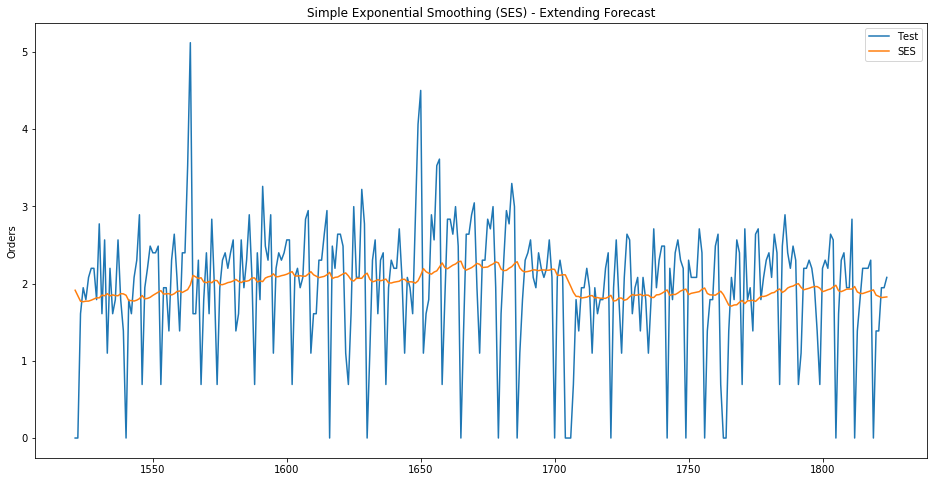

In [70]:
plt.figure(figsize=(16,8))
plt.plot(fb_df.y.iloc[1521:], label='Test')
plt.plot(fb_df.SES_extending_yhat.iloc[1521:], label='SES')
plt.legend(loc='best')
plt.ylabel('Orders')
plt.title('Simple Exponential Smoothing (SES) - Extending Forecast')
plt.show()

In [409]:
fb_df['extending_yhat'] = 0
extending_yhat = []

#Test/Prediction period starting from index/iloc = 305 to be able to compare results for same train size (305 days) to the train-test cv sizes from before
for index, row in fb_df.iloc[1521:].iterrows():

    train_model_holidays_1521 = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,growth='linear',holidays=holidays,holidays_prior_scale=20)
    #train_model_holidays_1521.add_seasonality(name='monthly', period=30.5, fourier_order=20)
    train_model_holidays_1521.fit(fb_df.iloc[:index])
    future_holidays_1521 = train_model_holidays_1521.make_future_dataframe(periods=1,include_history=False)
    forecast_holidays_1521 = train_model_holidays_1521.predict(future_holidays_1521)
    predictions_holidays_1521 = forecast_holidays_1521.yhat
    extending_yhat.append(predictions_holidays_1521)
fb_df['extending_yhat'].iloc[1521:] = extending_yhat

In [410]:
extending_expected = fb_df.y.iloc[1521:].tolist()
extending_1521_predictions = fb_df.extending_yhat.iloc[1521:].tolist()
mae_1521_extending = np.expm1(mean_absolute_error(extending_expected, extending_1521_predictions))
print((mae_1521_extending))
approx_mape = mean_absolute_error(extending_expected,extending_1521_predictions)
approx_mape

0.5372915346405143


0.43002212428007525

In [237]:
np.expm1(fb_df.y.iloc[1521:].mean())

6.180502747570113

In [73]:
fb_df['rolling_yhat'] = 0
rolling_yhat = []

#Test/Prediction period starting from index/iloc = 305 to be able to compare results for same train size (305 days) to the train-test cv sizes from before
for index, row in fb_df.iloc[1521:].iterrows():

    train_model_holidays_1521 = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,growth='linear',holidays=holidays)
    train_model_holidays_1521.fit(fb_df.iloc[index-365:index])
    future_holidays_1521 = train_model_holidays_1521.make_future_dataframe(periods=1,include_history=False)
    forecast_holidays_1521 = train_model_holidays_1521.predict(future_holidays_1521)
    predictions_holidays_1521 = forecast_holidays_1521.yhat
    rolling_yhat.append(predictions_holidays_1521)
fb_df['rolling_yhat'].iloc[1521:] = rolling_yhat

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [146]:
rolling_expected = fb_df.y.iloc[1521:].tolist()
rolling_1521_predictions = fb_df.rolling_yhat.iloc[1521:].tolist()
mae_1521_rolling = np.expm1(mean_absolute_error(rolling_expected, rolling_1521_predictions))
mae_1521_rolling

0.7408344512424427

In [159]:
test_list_4.groupby(test_list_4['ds'].dt.strftime('%Y-%W'))['y'].sum()

ds
2019-00     5.347108
2019-01    15.212626
2019-02    12.440037
2019-03    11.366743
2019-04    14.601886
2019-05    13.685493
2019-06    18.961606
2019-07    11.964511
2019-08    15.192754
2019-09    14.085843
2019-10    16.224227
2019-11    15.118646
2019-12    15.178282
2019-13    13.407542
2019-14    14.236912
2019-15    14.755518
2019-16    12.969212
2019-17    14.529048
2019-18    18.126868
2019-19    16.686944
2019-20    15.577882
2019-21    15.643826
2019-22    15.088076
2019-23    15.920620
2019-24    14.181153
2019-25    13.516177
2019-26     7.154615
2019-27    12.311621
2019-28    11.733987
2019-29    14.684679
2019-30    11.990897
2019-31    13.718118
2019-32    13.451638
2019-33    13.646855
2019-34    10.786924
2019-35    10.913487
2019-36    14.970881
2019-37    14.589463
2019-38    15.451037
2019-39    13.325076
2019-40    12.594188
2019-41    13.034952
2019-42    12.072313
2019-43     8.743851
Name: y, dtype: float64

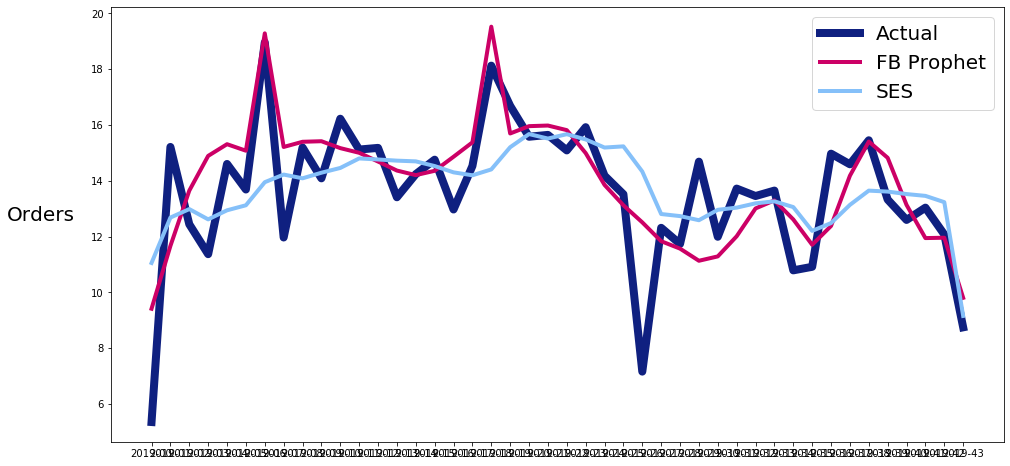

In [240]:
test_list_4 = pd.concat([X_test_list[4],y_test_list[4]], axis=1)
test_list_4_grouped = test_list_4.groupby(test_list_4['ds'].dt.strftime('%Y-%W'))['y'].sum()

forecast_holidays_cv_list_grouped = fb_df.iloc[1535:].groupby(fb_df.iloc[1535:]['ds'].dt.strftime('%Y-%W'))['extending_yhat'].sum()

SES_test_list_4_grouped = fb_df.iloc[1535:].groupby(fb_df.iloc[1535:]['ds'].dt.strftime('%Y-%W'))['SES_extending_yhat'].sum()

customfont = {'fontname':'Open Sans'}

fig, ax = plt.subplots(figsize=(16,8))

plt.plot(test_list_4_grouped, label='Actual', color = '#0F2080',linewidth=8)
plt.plot(forecast_holidays_cv_list_grouped, label='FB Prophet', color='#cc0066',linewidth=4)
plt.plot(SES_test_list_4_grouped, label='SES', color='#85C0F9',linewidth=4)
plt.legend(loc='best',prop={'family':'Open Sans', 'size':20})

# labels = [item.get_text() for item in ax.get_xticklabels()]

# labels_1 = test_list_4_grouped.iloc[test_list_4_grouped.reset_index().index.min()]
# labels_2 = test_list_4_grouped.iloc[int(round((int((test_list_4_grouped.reset_index().index.max()-test_list_4_grouped.reset_index().index.min())*1/5)+test_list_4_grouped.reset_index().index.min())/5)*5)]
# labels_3 = test_list_4_grouped.iloc[int(round((int((test_list_4_grouped.reset_index().index.max()-test_list_4_grouped.reset_index().index.min())*2/5)+test_list_4_grouped.reset_index().index.min())/5)*5)]
# labels_4 = test_list_4_grouped.iloc[int(round((int((test_list_4_grouped.reset_index().index.max()-test_list_4_grouped.reset_index().index.min())*3/5)+test_list_4_grouped.reset_index().index.min())/5)*5)]
# labels_5 = test_list_4_grouped.iloc[int(round((int((test_list_4_grouped.reset_index().index.max()-test_list_4_grouped.reset_index().index.min())*4/5)+test_list_4_grouped.reset_index().index.min())/5)*5)]
# labels_6 = test_list_4_grouped.iloc[test_list_4_grouped.reset_index().index.max()]
        
    
# labels[1] = datetime.strftime(labels_1.date(), '%m-%d')
# labels[2] = datetime.strftime(labels_2.date(), '%m-%d')
# labels[3] = datetime.strftime(labels_3.date(), '%m-%d')
# labels[4] = datetime.strftime(labels_4.date(), '%m-%d')
# labels[5] = datetime.strftime(labels_5.date(), '%m-%d')
# labels[6] = datetime.strftime(labels_6.date(), '%m-%d')
# ax.set_xticklabels(labels, fontsize =20, **customfont)
# ax.set_xticklabels(fontsize =20, **customfont)

# y_labels = [-6, 0, 10, 15, 20, 25]
# ax.set_yticklabels(y_labels, fontsize =20, **customfont)


plt.ylabel('Orders', fontsize = 20, rotation = 0, **customfont,labelpad=50)
plt.show()

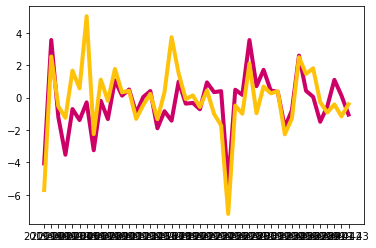

In [163]:
plt.plot(test_list_4_grouped-forecast_holidays_cv_list_grouped, label='FB Prophet', color='#cc0066',linewidth=4)
plt.plot(test_list_4_grouped-SES_test_list_4_grouped, label='SES Forecast', color='#FFC20A',linewidth=4)

In [209]:
X_test_list[4].loc[X_test_list[4].idxmin()]
test_list_4['ds']

1521   2019-01-02
1522   2019-01-03
1523   2019-01-04
1524   2019-01-05
1525   2019-01-06
          ...    
1820   2019-10-28
1821   2019-10-29
1822   2019-10-30
1823   2019-10-31
1824   2019-11-01
Name: ds, Length: 304, dtype: datetime64[ns]

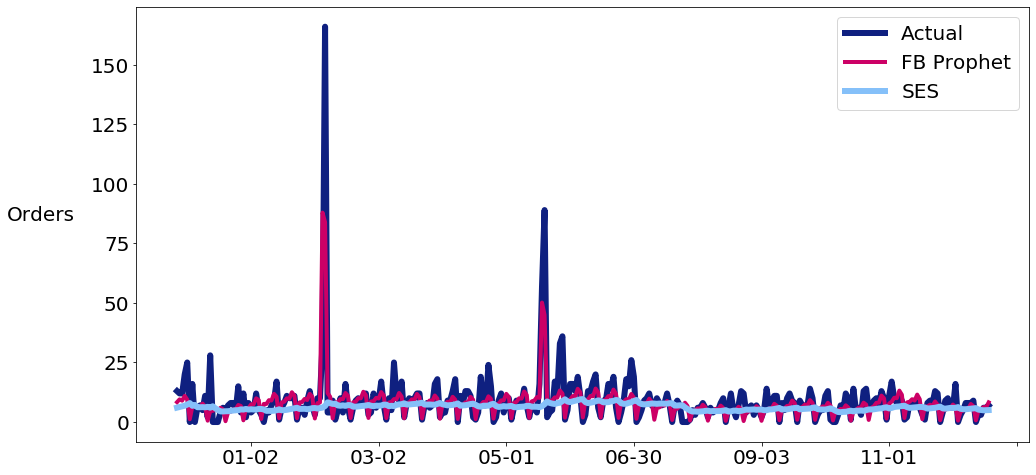

In [258]:
test_list_4 = pd.concat([X_test_list[4],y_test_list[4]], axis=1)
test_list_4_grouped = np.expm1(test_list_4.groupby(test_list_4['ds'].dt.strftime('%Y-%W'))['y'].sum())

forecast_holidays_cv_list_grouped = np.expm1(fb_df.iloc[1535:].groupby(fb_df.iloc[1535:]['ds'].dt.strftime('%Y-%W'))['extending_yhat'].sum())

SES_test_list_4_grouped = np.expm1(fb_df.iloc[1535:].groupby(fb_df.iloc[1535:]['ds'].dt.strftime('%Y-%W'))['SES_extending_yhat'].sum())

customfont = {'fontname':'Open Sans'}

fig, ax = plt.subplots(figsize=(16,8))

plt.plot(np.expm1(fb_df.y.iloc[1521:]), label='Actual', color = '#0F2080',linewidth=6)
plt.plot(np.expm1(fb_df['extending_yhat'][1521:]), label='FB Prophet', color='#cc0066',linewidth=4)
plt.plot(np.expm1(fb_df['SES_extending_yhat'][1521:]), label='SES', color='#85C0F9',linewidth=6)
plt.legend(loc='best',prop={'family':'Open Sans', 'size':20})

labels = [item.get_text() for item in ax.get_xticklabels()]

labels_1 = X_test_list[4].loc[X_test_list[4].idxmin()]
labels_2 = X_test_list[4].loc[int(round((int((X_test_list[4].idxmax()-X_test_list[4].idxmin())*1/5)+X_test_list[4].idxmin())/5)*5)]
labels_3 = X_test_list[4].loc[int(round((int((X_test_list[4].idxmax()-X_test_list[4].idxmin())*2/5)+X_test_list[4].idxmin())/5)*5)]
labels_4 = X_test_list[4].loc[int(round((int((X_test_list[4].idxmax()-X_test_list[4].idxmin())*3/5)+X_test_list[4].idxmin())/5)*5)]
labels_5 = X_test_list[4].loc[int(round((int((X_test_list[4].idxmax()-X_test_list[4].idxmin())*4/5)+X_test_list[4].idxmin())/5)*5)]
labels_6 = X_test_list[4].loc[X_test_list[4].idxmax()]
        
    
labels[1] = datetime.strftime(labels_1.date(), '%m-%d')
labels[2] = datetime.strftime(labels_2.date(), '%m-%d')
labels[3] = datetime.strftime(labels_3.date(), '%m-%d')
labels[4] = datetime.strftime(labels_4.date(), '%m-%d')
labels[5] = datetime.strftime(labels_5.date(), '%m-%d')
labels[6] = datetime.strftime(labels_6.date(), '%m-%d')
ax.set_xticklabels(labels, fontsize =20, **customfont)
# ax.set_xticklabels(fontsize =20, **customfont)

y_labels = [-25, 0, 25, 50, 75, 100, 125, 150]
ax.set_yticklabels(y_labels, fontsize =20, **customfont)


plt.ylabel('Orders', fontsize = 20, rotation = 0, **customfont,labelpad=50)
plt.show()

In [215]:
print(fb_df.ds.iloc[1521:].loc[1550])
print(fb_df.ds.iloc[1521:].loc[1600])
print(fb_df.ds.iloc[1521:].loc[1650])
print(fb_df.ds.iloc[1521:].loc[1700])
print(fb_df.ds.iloc[1521:].loc[1750])
print(fb_df.ds.iloc[1521:].loc[1800])

2019-01-16 00:00:00
2019-03-07 00:00:00
2019-04-26 00:00:00
2019-06-15 00:00:00
2019-08-04 00:00:00
2019-09-23 00:00:00


In [402]:
fb_df

,ds,y
0,2014-10-19,0.000000
1,2014-10-20,0.000000
2,2014-10-21,0.000000
3,2014-10-22,0.000000
4,2014-10-23,0.000000
...,...,...
1835,2019-10-28,1.386294
1836,2019-10-29,1.386294
1837,2019-10-30,1.945910
1838,2019-10-31,1.945910


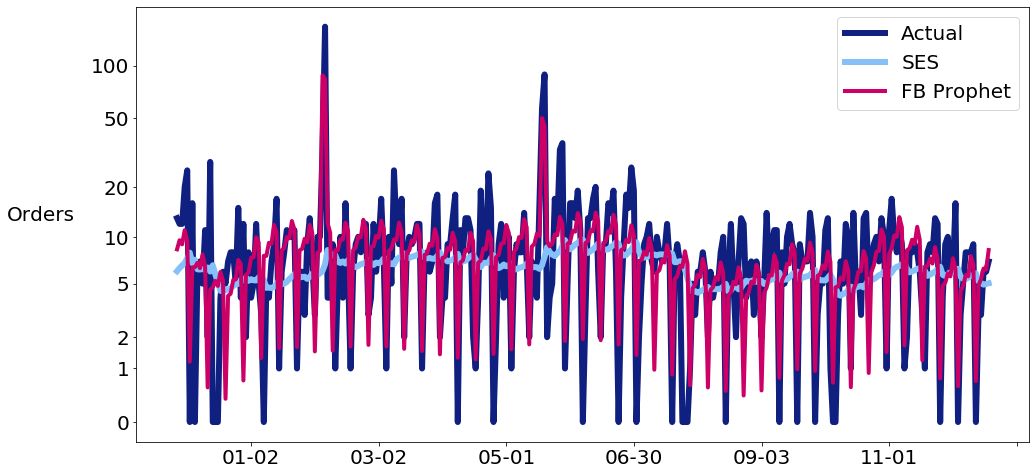

In [411]:
# test_list_4 = pd.concat([X_test_list[4],y_test_list[4]], axis=1)
# test_list_4_grouped = np.expm1(test_list_4.groupby(test_list_4['ds'].dt.strftime('%Y-%W'))['y'].sum())

# forecast_holidays_cv_list_grouped = np.expm1(fb_df.iloc[1535:].groupby(fb_df.iloc[1535:]['ds'].dt.strftime('%Y-%W'))['extending_yhat'].sum())

# SES_test_list_4_grouped = np.expm1(fb_df.iloc[1535:].groupby(fb_df.iloc[1535:]['ds'].dt.strftime('%Y-%W'))['SES_extending_yhat'].sum())

customfont = {'fontname':'Open Sans'}

fig, ax = plt.subplots(figsize=(16,8))

plt.plot(fb_df.y.iloc[1521:], label='Actual', color = '#0F2080',linewidth=6)
plt.plot(fb_df['SES_extending_yhat'][1521:], label='SES', color='#85C0F9',linewidth=6)
plt.plot(fb_df['extending_yhat'][1521:], label='FB Prophet', color='#cc0066',linewidth=4)

plt.legend(loc='best',prop={'family':'Open Sans', 'size':20})

labels = [item.get_text() for item in ax.get_xticklabels()]

labels_1 = X_test_list[4].loc[X_test_list[4].idxmin()]
labels_2 = X_test_list[4].loc[int(round((int((X_test_list[4].idxmax()-X_test_list[4].idxmin())*1/5)+X_test_list[4].idxmin())/5)*5)]
labels_3 = X_test_list[4].loc[int(round((int((X_test_list[4].idxmax()-X_test_list[4].idxmin())*2/5)+X_test_list[4].idxmin())/5)*5)]
labels_4 = X_test_list[4].loc[int(round((int((X_test_list[4].idxmax()-X_test_list[4].idxmin())*3/5)+X_test_list[4].idxmin())/5)*5)]
labels_5 = X_test_list[4].loc[int(round((int((X_test_list[4].idxmax()-X_test_list[4].idxmin())*4/5)+X_test_list[4].idxmin())/5)*5)]
labels_6 = X_test_list[4].loc[X_test_list[4].idxmax()]
        
    
labels[1] = datetime.strftime(labels_1.date(), '%m-%d')
labels[2] = datetime.strftime(labels_2.date(), '%m-%d')
labels[3] = datetime.strftime(labels_3.date(), '%m-%d')
labels[4] = datetime.strftime(labels_4.date(), '%m-%d')
labels[5] = datetime.strftime(labels_5.date(), '%m-%d')
labels[6] = datetime.strftime(labels_6.date(), '%m-%d')
ax.set_xticklabels(labels, fontsize =20, **customfont)
#ax.set_xticklabels(fontsize =20, **customfont)

y_labels = [0,1,2,5,10,20,50,100]
plt.yticks(np.log1p(np.array(y_labels)))
ax.set_yticklabels(y_labels, fontsize =20, **customfont)

plt.ylabel('Orders', fontsize = 20, rotation = 0, **customfont,labelpad=50)
plt.show()
fig.savefig('results.svg',pad_inches=3)

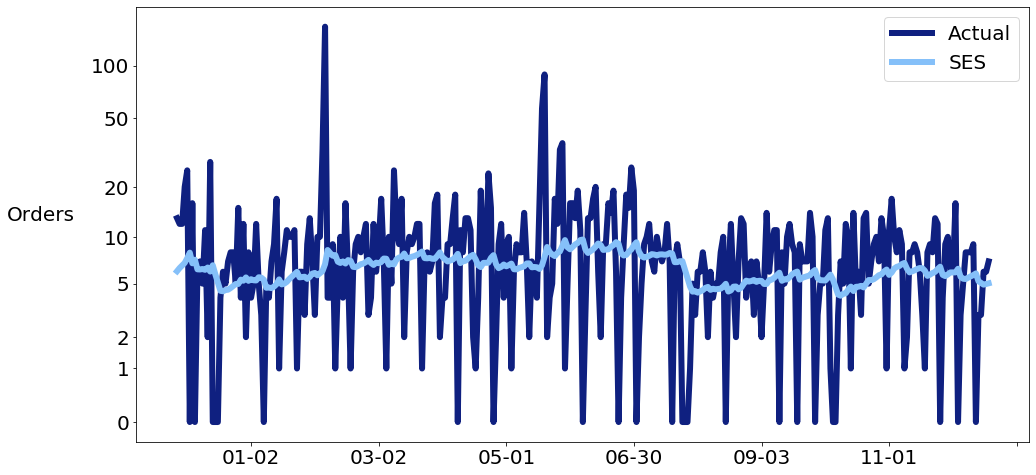

In [406]:
customfont = {'fontname':'Open Sans'}

fig, ax = plt.subplots(figsize=(16,8))

plt.plot(fb_df.y.iloc[1521:], label='Actual', color = '#0F2080',linewidth=6)
plt.plot(fb_df['SES_extending_yhat'][1521:], label='SES', color='#85C0F9',linewidth=6)
plt.legend(loc='best',prop={'family':'Open Sans', 'size':20})

labels = [item.get_text() for item in ax.get_xticklabels()]

labels_1 = X_test_list[4].loc[X_test_list[4].idxmin()]
labels_2 = X_test_list[4].loc[int(round((int((X_test_list[4].idxmax()-X_test_list[4].idxmin())*1/5)+X_test_list[4].idxmin())/5)*5)]
labels_3 = X_test_list[4].loc[int(round((int((X_test_list[4].idxmax()-X_test_list[4].idxmin())*2/5)+X_test_list[4].idxmin())/5)*5)]
labels_4 = X_test_list[4].loc[int(round((int((X_test_list[4].idxmax()-X_test_list[4].idxmin())*3/5)+X_test_list[4].idxmin())/5)*5)]
labels_5 = X_test_list[4].loc[int(round((int((X_test_list[4].idxmax()-X_test_list[4].idxmin())*4/5)+X_test_list[4].idxmin())/5)*5)]
labels_6 = X_test_list[4].loc[X_test_list[4].idxmax()]
        
    
labels[1] = datetime.strftime(labels_1.date(), '%m-%d')
labels[2] = datetime.strftime(labels_2.date(), '%m-%d')
labels[3] = datetime.strftime(labels_3.date(), '%m-%d')
labels[4] = datetime.strftime(labels_4.date(), '%m-%d')
labels[5] = datetime.strftime(labels_5.date(), '%m-%d')
labels[6] = datetime.strftime(labels_6.date(), '%m-%d')
ax.set_xticklabels(labels, fontsize =20, **customfont)
#ax.set_xticklabels(fontsize =20, **customfont)

y_labels = [0,1,2,5,10,20,50,100]
plt.yticks(np.log1p(np.array(y_labels)))
ax.set_yticklabels(y_labels, fontsize =20, **customfont)

plt.ylabel('Orders', fontsize = 20, rotation = 0, **customfont,labelpad=50)
plt.show()
fig.savefig('results2.svg',pad_inches=3)

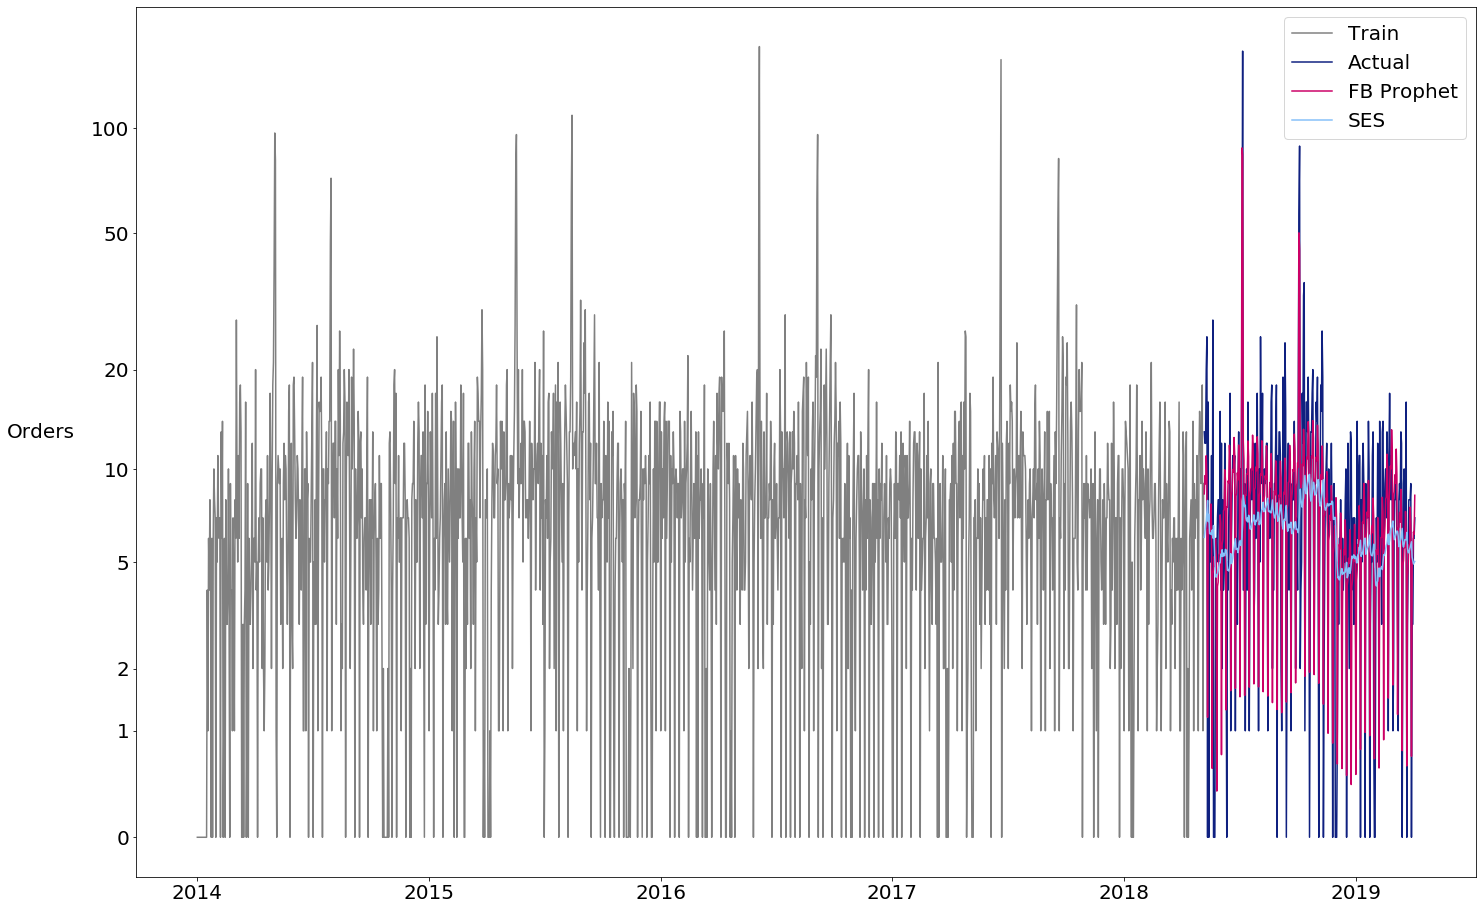

In [427]:
customfont = {'fontname':'Open Sans'}

fig, ax = plt.subplots(figsize=(24,16))

plt.plot(fb_df.y.iloc[:1521], label='Train', color = 'grey')
plt.plot(fb_df.y.iloc[1521:], label='Actual', color = '#0F2080')
plt.plot(fb_df['extending_yhat'][1521:], label='FB Prophet', color='#cc0066')
plt.plot(fb_df['SES_extending_yhat'][1521:], label='SES', color='#85C0F9')
plt.legend(loc='upper right',prop={'family':'Open Sans', 'size':20})

labels = [item.get_text() for item in ax.get_xticklabels()]

plt.xticks(np.arange(0,2100,step=350))
# labels_1 = fb_df['ds'].loc[fb_df['ds'].idxmin()]
# labels_2 = fb_df['ds'].loc[int(round((int((fb_df['ds'].idxmax()-fb_df['ds'].idxmin())*1/5)+fb_df['ds'].idxmin())/5)*5)]
# labels_3 = fb_df['ds'].loc[int(round((int((fb_df['ds'].idxmax()-fb_df['ds'].idxmin())*2/5)+fb_df['ds'].idxmin())/5)*5)]
# labels_4 = fb_df['ds'].loc[int(round((int((fb_df['ds'].idxmax()-fb_df['ds'].idxmin())*3/5)+fb_df['ds'].idxmin())/5)*5)]
# labels_5 = fb_df['ds'].loc[int(round((int((fb_df['ds'].idxmax()-fb_df['ds'].idxmin())*4/5)+fb_df['ds'].idxmin())/5)*5)]
# labels_6 = fb_df['ds'].loc[fb_df['ds'].idxmax()]

labels[0] = 2014
labels[1] = 2015
labels[2] = 2016
labels[3] = 2017
labels[4] = 2018
labels[5] = 2019

    
# labels[1] = datetime.strftime(labels_1.date(), '%Y')
# labels[2] = datetime.strftime(labels_2.date(), '%Y')
# labels[3] = datetime.strftime(labels_3.date(), '%Y')
# labels[4] = datetime.strftime(labels_4.date(), '%Y')
# labels[5] = datetime.strftime(labels_5.date(), '%Y')
# labels[6] = datetime.strftime(labels_6.date(), '%Y')
ax.set_xticklabels(labels, fontsize =20, **customfont)
#ax.set_xticklabels(fontsize =20, **customfont)

y_labels = [0,1,2,5,10,20,50,100]
plt.yticks(np.log1p(np.array(y_labels)))
ax.set_yticklabels(y_labels, fontsize =20, **customfont)

plt.ylabel('Orders', fontsize = 20, rotation = 0, **customfont,labelpad=50)
plt.show()
fig.savefig('results_train.svg',pad_inches=3)

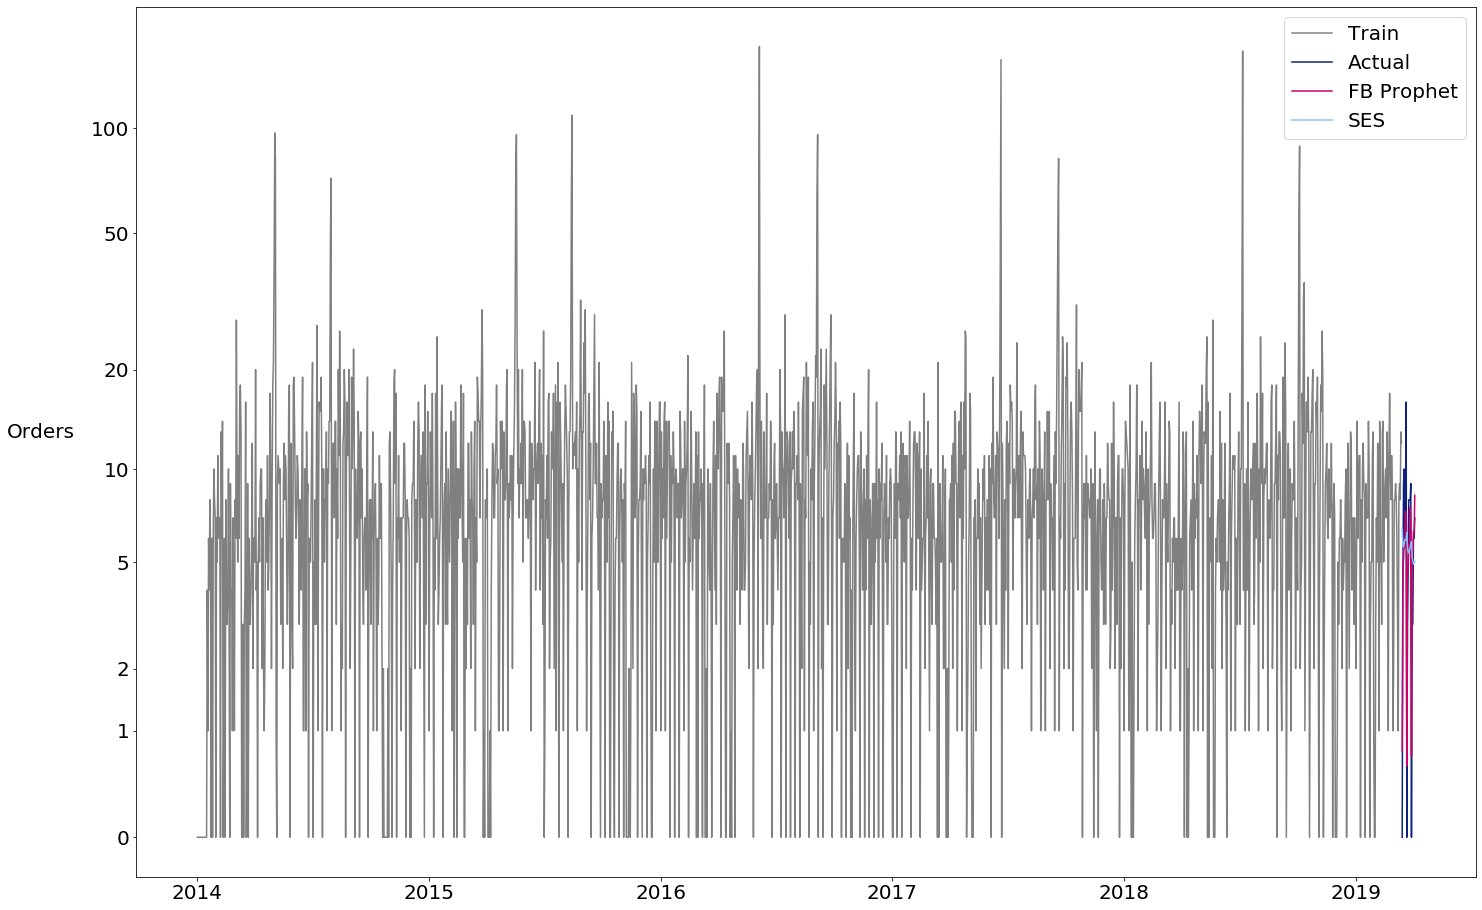

In [432]:
customfont = {'fontname':'Open Sans'}

fig, ax = plt.subplots(figsize=(24,16))

plt.plot(fb_df.y.iloc[:1820], label='Train', color = 'grey')
plt.plot(fb_df.y.iloc[1820:], label='Actual', color = '#0F2080')
plt.plot(fb_df['extending_yhat'][1820:], label='FB Prophet', color='#cc0066')
plt.plot(fb_df['SES_extending_yhat'][1820:], label='SES', color='#85C0F9')
plt.legend(loc='upper right',prop={'family':'Open Sans', 'size':20})

labels = [item.get_text() for item in ax.get_xticklabels()]

plt.xticks(np.arange(0,2100,step=350))
# labels_1 = fb_df['ds'].loc[fb_df['ds'].idxmin()]
# labels_2 = fb_df['ds'].loc[int(round((int((fb_df['ds'].idxmax()-fb_df['ds'].idxmin())*1/5)+fb_df['ds'].idxmin())/5)*5)]
# labels_3 = fb_df['ds'].loc[int(round((int((fb_df['ds'].idxmax()-fb_df['ds'].idxmin())*2/5)+fb_df['ds'].idxmin())/5)*5)]
# labels_4 = fb_df['ds'].loc[int(round((int((fb_df['ds'].idxmax()-fb_df['ds'].idxmin())*3/5)+fb_df['ds'].idxmin())/5)*5)]
# labels_5 = fb_df['ds'].loc[int(round((int((fb_df['ds'].idxmax()-fb_df['ds'].idxmin())*4/5)+fb_df['ds'].idxmin())/5)*5)]
# labels_6 = fb_df['ds'].loc[fb_df['ds'].idxmax()]

labels[0] = 2014
labels[1] = 2015
labels[2] = 2016
labels[3] = 2017
labels[4] = 2018
labels[5] = 2019

    
# labels[1] = datetime.strftime(labels_1.date(), '%Y')
# labels[2] = datetime.strftime(labels_2.date(), '%Y')
# labels[3] = datetime.strftime(labels_3.date(), '%Y')
# labels[4] = datetime.strftime(labels_4.date(), '%Y')
# labels[5] = datetime.strftime(labels_5.date(), '%Y')
# labels[6] = datetime.strftime(labels_6.date(), '%Y')
ax.set_xticklabels(labels, fontsize =20, **customfont)
#ax.set_xticklabels(fontsize =20, **customfont)

y_labels = [0,1,2,5,10,20,50,100]
plt.yticks(np.log1p(np.array(y_labels)))
ax.set_yticklabels(y_labels, fontsize =20, **customfont)

plt.ylabel('Orders', fontsize = 20, rotation = 0, **customfont,labelpad=50)
plt.show()
fig.savefig('results_train4.svg',pad_inches=3)

In [344]:
y_labels = [0,1,10,20,50,150]
list(np.log1p(np.array(y_labels)))


[0.0,
 0.6931471805599453,
 2.3978952727983707,
 3.044522437723423,
 3.9318256327243257,
 5.017279836814924]

In [332]:
print(np.log1p(0))
print(round(np.log1p(1)))
print(np.log1p(2))
print(np.log1p(5))
print(np.log1p(10))
print(np.log1p(20))
print(round(np.log1p(30)))
print(np.log1p(40))
print(np.log1p(50))
print(np.log1p(60))
print(round(np.log1p(70)))
print(round(np.log1p(80)))
print(round(np.log1p(90)))
print(round(np.log1p(100)))
print(round(np.log1p(110)))
print(round(np.log1p(120)))
print(round(np.log1p(130)))
print(round(np.log1p(140)))
print(round(np.log1p(150)))

0.0
1.0
1.0986122886681098
1.791759469228055
2.3978952727983707
3.044522437723423
3.0
3.713572066704308
3.9318256327243257
4.110873864173311
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


In [316]:
print(np.expm1(0))
print(np.expm1(1.8))
print(np.expm1(2.4))
print(np.expm1(2.4))
print(np.expm1(3))
print(np.expm1(4))
print(np.expm1(5.02))

0.0
5.0496474644129465
10.023176380641601
10.023176380641601
19.085536923187668
53.598150033144236
148.90473614904667


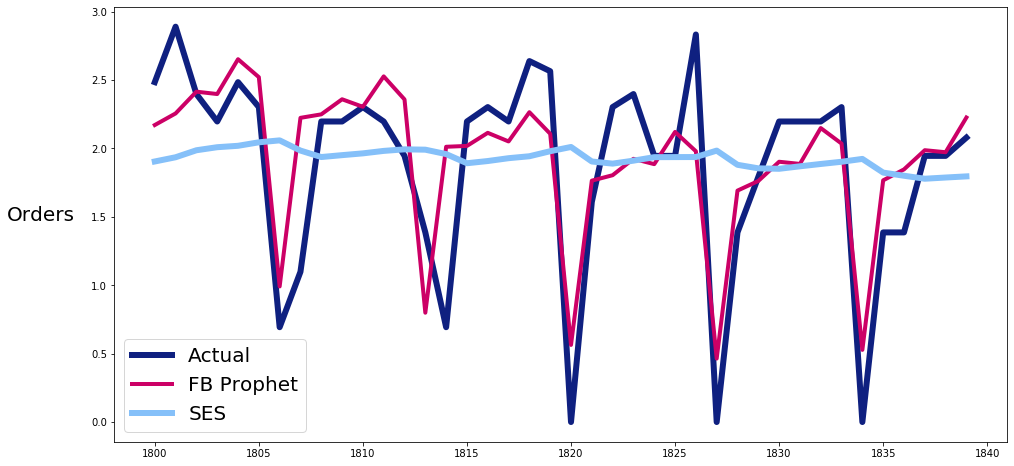

In [270]:
# test_list_4 = pd.concat([X_test_list[4],y_test_list[4]], axis=1)
# test_list_4_grouped = np.expm1(test_list_4.groupby(test_list_4['ds'].dt.strftime('%Y-%W'))['y'].sum())

# forecast_holidays_cv_list_grouped = np.expm1(fb_df.iloc[1535:].groupby(fb_df.iloc[1535:]['ds'].dt.strftime('%Y-%W'))['extending_yhat'].sum())

# SES_test_list_4_grouped = np.expm1(fb_df.iloc[1535:].groupby(fb_df.iloc[1535:]['ds'].dt.strftime('%Y-%W'))['SES_extending_yhat'].sum())

customfont = {'fontname':'Open Sans'}

fig, ax = plt.subplots(figsize=(16,8))

plt.plot(fb_df.y.iloc[1800:], label='Actual', color = '#0F2080',linewidth=6)
plt.plot(fb_df['extending_yhat'][1800:], label='FB Prophet', color='#cc0066',linewidth=4)
plt.plot(fb_df['SES_extending_yhat'][1800:], label='SES', color='#85C0F9',linewidth=6)
plt.legend(loc='best',prop={'family':'Open Sans', 'size':20})

# labels = [item.get_text() for item in ax.get_xticklabels()]

# labels_1 = X_test_list[4].loc[X_test_list[4].idxmin()]
# labels_2 = X_test_list[4].loc[int(round((int((X_test_list[4].idxmax()-X_test_list[4].idxmin())*1/5)+X_test_list[4].idxmin())/5)*5)]
# labels_3 = X_test_list[4].loc[int(round((int((X_test_list[4].idxmax()-X_test_list[4].idxmin())*2/5)+X_test_list[4].idxmin())/5)*5)]
# labels_4 = X_test_list[4].loc[int(round((int((X_test_list[4].idxmax()-X_test_list[4].idxmin())*3/5)+X_test_list[4].idxmin())/5)*5)]
# labels_5 = X_test_list[4].loc[int(round((int((X_test_list[4].idxmax()-X_test_list[4].idxmin())*4/5)+X_test_list[4].idxmin())/5)*5)]
# labels_6 = X_test_list[4].loc[X_test_list[4].idxmax()]
        
    
# labels[1] = datetime.strftime(labels_1.date(), '%m-%d')
# labels[2] = datetime.strftime(labels_2.date(), '%m-%d')
# labels[3] = datetime.strftime(labels_3.date(), '%m-%d')
# labels[4] = datetime.strftime(labels_4.date(), '%m-%d')
# labels[5] = datetime.strftime(labels_5.date(), '%m-%d')
# labels[6] = datetime.strftime(labels_6.date(), '%m-%d')
# ax.set_xticklabels(labels, fontsize =20, **customfont)
#ax.set_xticklabels(fontsize =20, **customfont)

# y_labels = [-1, 0, 1, 2, 3, 4, 5, 6]
# ax.set_yticklabels(y_labels, fontsize =20, **customfont)


plt.ylabel('Orders', fontsize = 20, rotation = 0, **customfont,labelpad=50)
plt.show()

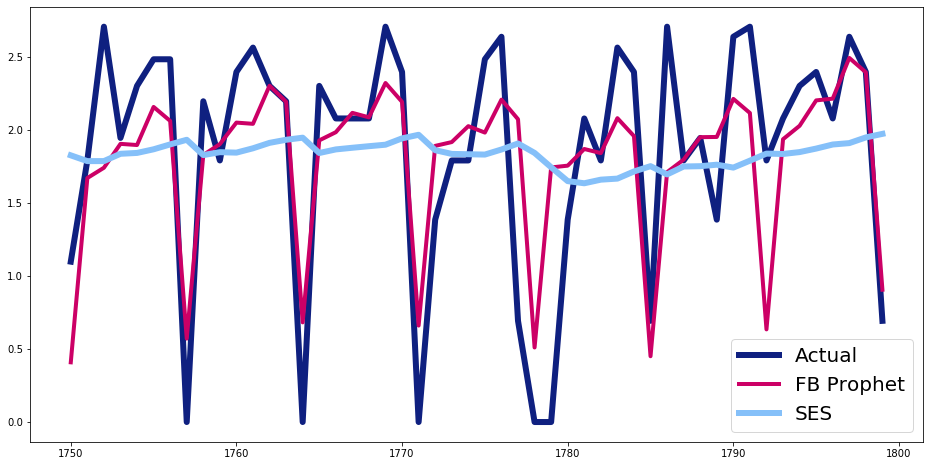

In [264]:
customfont = {'fontname':'Open Sans'}

fig, ax = plt.subplots(figsize=(16,8))

plt.plot(fb_df.y.iloc[1750:1800], label='Actual', color = '#0F2080',linewidth=6)
plt.plot(fb_df['extending_yhat'][1750:1800], label='FB Prophet', color='#cc0066',linewidth=4)
plt.plot(fb_df['SES_extending_yhat'][1750:1800], label='SES', color='#85C0F9',linewidth=6)
plt.legend(loc='best',prop={'family':'Open Sans', 'size':20})

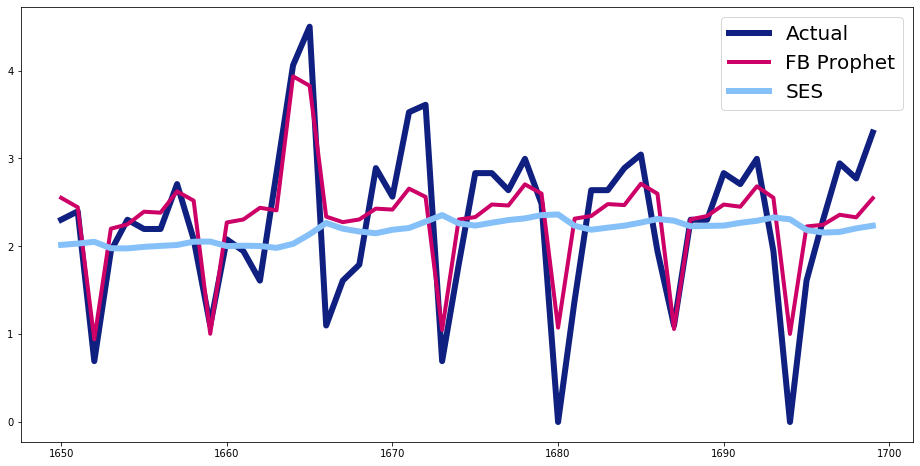

In [266]:
customfont = {'fontname':'Open Sans'}

fig, ax = plt.subplots(figsize=(16,8))

plt.plot(fb_df.y.iloc[1650:1700], label='Actual', color = '#0F2080',linewidth=6)
plt.plot(fb_df['extending_yhat'][1650:1700], label='FB Prophet', color='#cc0066',linewidth=4)
plt.plot(fb_df['SES_extending_yhat'][1650:1700], label='SES', color='#85C0F9',linewidth=6)
plt.legend(loc='best',prop={'family':'Open Sans', 'size':20})

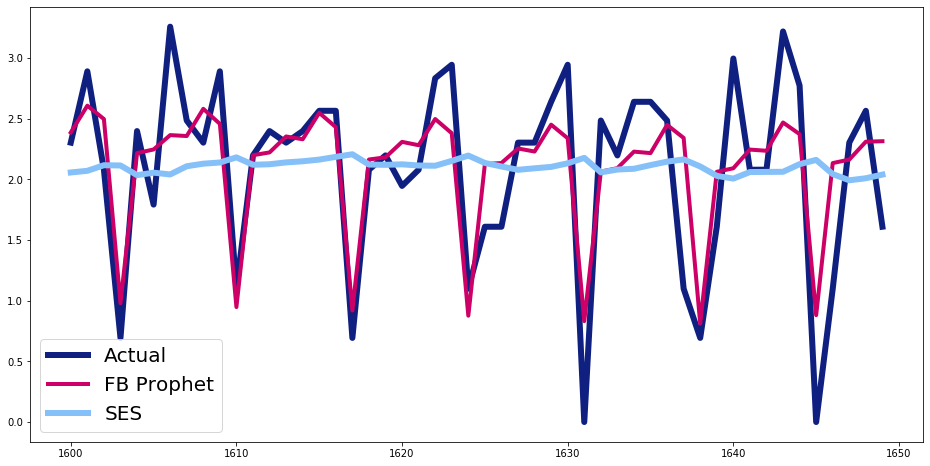

In [267]:
customfont = {'fontname':'Open Sans'}

fig, ax = plt.subplots(figsize=(16,8))

plt.plot(fb_df.y.iloc[1600:1650], label='Actual', color = '#0F2080',linewidth=6)
plt.plot(fb_df['extending_yhat'][1600:1650], label='FB Prophet', color='#cc0066',linewidth=4)
plt.plot(fb_df['SES_extending_yhat'][1600:1650], label='SES', color='#85C0F9',linewidth=6)
plt.legend(loc='best',prop={'family':'Open Sans', 'size':20})

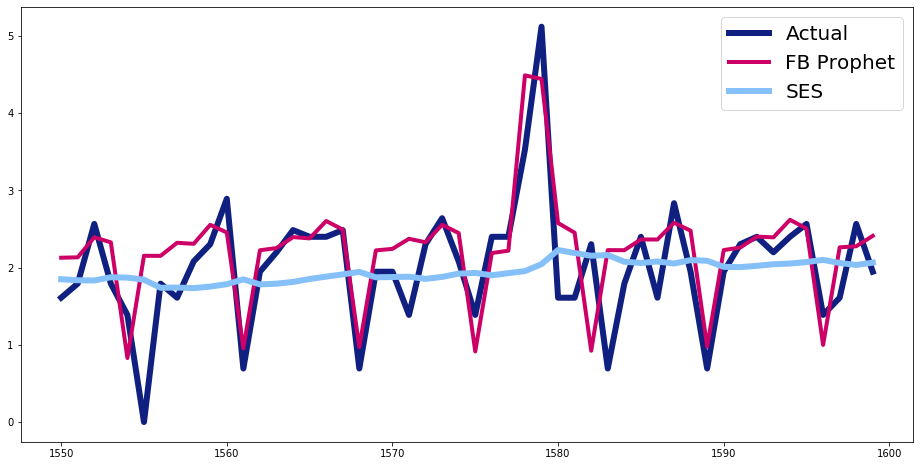

In [268]:
fig, ax = plt.subplots(figsize=(16,8))

plt.plot(fb_df.y.iloc[1550:1600], label='Actual', color = '#0F2080',linewidth=6)
plt.plot(fb_df['extending_yhat'][1550:1600], label='FB Prophet', color='#cc0066',linewidth=4)
plt.plot(fb_df['SES_extending_yhat'][1550:1600], label='SES', color='#85C0F9',linewidth=6)
plt.legend(loc='best',prop={'family':'Open Sans', 'size':20})

In [231]:
print(np.expm1(0))
print(int(np.expm1(1)))
print(int(np.expm1(2)))
print(int(np.expm1(3)))
print(int(np.expm1(4)))
print(int(np.expm1(5)))

0.0
1
6
19
53
147


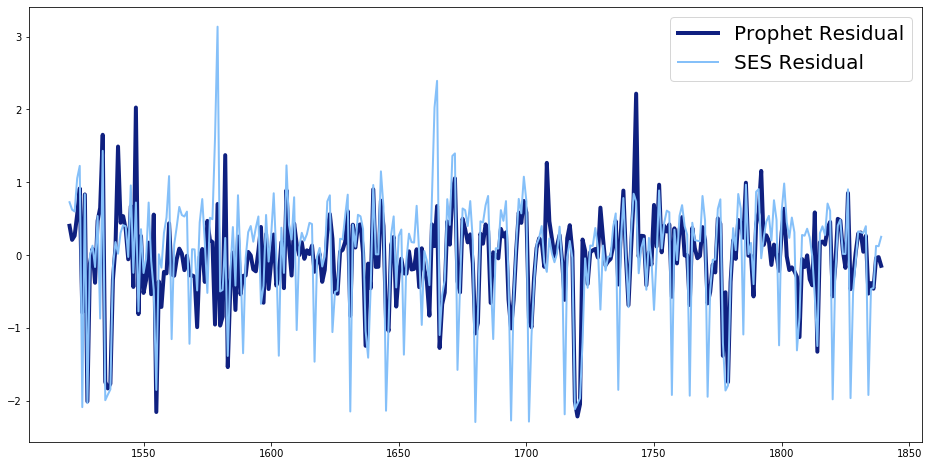

In [223]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(fb_df.y.iloc[1521:]-fb_df['extending_yhat'][1521:], label='Prophet Residual', color = '#0F2080',linewidth=4)
plt.plot(fb_df.y.iloc[1521:]-fb_df['SES_extending_yhat'][1521:], label='SES Residual', color='#85C0F9',linewidth=2)
plt.legend(loc='best',prop={'family':'Open Sans', 'size':20})

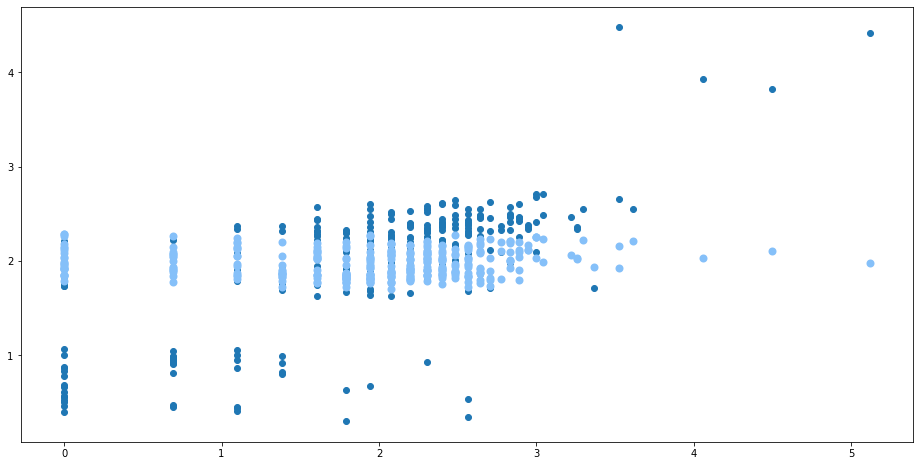

In [225]:
plt.figure(figsize=(16,8))

plt.scatter(fb_df.y.iloc[1521:],fb_df['extending_yhat'][1521:])
plt.scatter(fb_df.y.iloc[1521:],fb_df['SES_extending_yhat'][1521:], label='SES Residual', color='#85C0F9',linewidth=2)


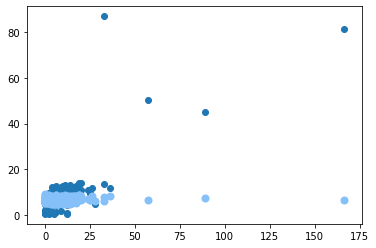

In [226]:
plt.scatter(np.expm1(fb_df.y.iloc[1521:]),np.expm1(fb_df['extending_yhat'][1521:]))
plt.scatter(np.expm1(fb_df.y.iloc[1521:]),np.expm1(fb_df['SES_extending_yhat'][1521:]), label='SES Residual', color='#85C0F9',linewidth=2)


In [211]:
fb_df['ds'][1536:]

1536   2019-01-02
1537   2019-01-03
1538   2019-01-04
1539   2019-01-05
1540   2019-01-06
          ...    
1835   2019-10-28
1836   2019-10-29
1837   2019-10-30
1838   2019-10-31
1839   2019-11-01
Name: ds, Length: 304, dtype: datetime64[ns]

# Cleaning Text in Product Descriptions

In [85]:
blank_description = prod_order201419[prod_order201419['Description'].isnull()]

In [86]:
prod_order201419.dropna(subset=['Description'], how='all', inplace=True)
prod_order201419.drop(['Loyalty','Gift Card','Discount','Tax','Nontaxable Delivery','Wire Out Fee'],axis=1,inplace=True)

# import re
# for row in prod_order201419['Description'].astype(str):
#     row = re.sub(r"([a-z])\-([a-z])", r"\1 \2", row)
#     row = re.sub(r"([a-z])\- ", r"\1 ", row)
    
for i, col in enumerate(prod_order201419):
    prod_order201419.iloc[:, i] = prod_order201419.iloc[:, i].astype(str).str.replace('"', '')
for i, col in enumerate(prod_order201419):
    prod_order201419.iloc[:, i] = prod_order201419.iloc[:, i].astype(str).str.replace('quot;', '')
for i, col in enumerate(prod_order201419):
    prod_order201419.iloc[:, i] = prod_order201419.iloc[:, i].astype(str).str.replace('&quot', '')
for i, col in enumerate(prod_order201419):
    prod_order201419.iloc[:, i] = prod_order201419.iloc[:, i].astype(str).str.replace('-', ' ')
for i, col in enumerate(prod_order201419):
    prod_order201419.iloc[:, i] = prod_order201419.iloc[:, i].astype(str).str.replace('/', ' ')
#for i, col in enumerate(prod_order201419):
    #prod_order201419.iloc[:, i] = prod_order201419.iloc[:, i].astype(str).str.replace('\', ' ')
for i, col in enumerate(prod_order201419):
    prod_order201419.iloc[:, i] = prod_order201419.iloc[:, i].astype(str).str.replace('_', ' ')
for i, col in enumerate(prod_order201419):
    prod_order201419.iloc[:, i] = prod_order201419.iloc[:, i].astype(str).str.replace('(', ' ')
for i, col in enumerate(prod_order201419):
    prod_order201419.iloc[:, i] = prod_order201419.iloc[:, i].astype(str).str.replace(')', ' ')
for i, col in enumerate(prod_order201419):
    prod_order201419.iloc[:, i] = prod_order201419.iloc[:, i].astype(str).str.replace('dc', 'designer choice ')
    
#prod_order201419.mask(prod_order201419.Description.str.contains(r'^[\.|/-_]'),inplace=True)

In [87]:
prod_order201419

,Order #,Product ID,Product Name,Description,Category,QTY,Transaction Type,Order Time,Order Date,Delivery Date,...,Taxable Delivery,Grand Total,Payment Method,Order Type,Customer Type,Order DateTime,Order Year,Delivery DateTime,Delivery Year,Price_Bin
0,100006572,takeorder,Special Product For POS,1 Designer's Choice,Uncategorized,1,HA Payment,03:14:23pm Mon,"Dec 14, 2015","Nov 04, 2015",...,$15.00,$92.23,Check Money order,Delivery,Phone,2015 12 14,2015,2015 11 04,2015,$75 99.99
1,100006571,takeorder,Special Product For POS,1 Orchid Plant,Uncategorized,1,Sale,04:43:49pm Mon,"Nov 02, 2015","Nov 04, 2015",...,$15.00,$75.95,Credit Card,Delivery,Phone,2015 11 02,2015,2015 11 04,2015,$75 99.99
2,100006570,takeorder,Special Product For POS,1 Orchid Arrangement,Uncategorized,1,Sale,04:02:16pm Mon,"Nov 02, 2015","Nov 02, 2015",...,$0.00,$80.00,Credit Card,Pickup,Phone,2015 11 02,2015,2015 11 02,2015,$75 99.99
3,100006569,takeorder,Special Product For POS,"1 Anthurium plant, dressed up",Uncategorized,1,Sale,02:10:30pm Mon,"Nov 02, 2015","Nov 05, 2015",...,$15.00,$75.95,Credit Card,Delivery,Phone,2015 11 02,2015,2015 11 05,2015,$75 99.99
4,100006567,takeorder,Special Product For POS,1 Fruit and Floral Arrangement,Uncategorized,1,Sale,01:42:12pm Mon,"Nov 02, 2015","Nov 03, 2015",...,$20.00,$500.00,Credit Card,Delivery,Phone,2015 11 02,2015,2015 11 03,2015,$400 499.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16957,100017199,takeorder,Special Product For POS,"Designers Choice Ikebana ,Seasonal colors of\...",Uncategorized,1,Sale,04:51:20pm Mon,"Nov 05, 2018","Nov 06, 2018",...,$20.00,$92.01,Credit Card,Delivery,Phone,2018 11 05,2018,2018 11 06,2018,$75 99.99
16958,100017198,takeorder,Special Product For POS,Ikebana Orchid Explosion,Uncategorized,1,Sale,04:43:15pm Mon,"Nov 05, 2018","Nov 08, 2018",...,$20.00,$124.49,Credit Card,Delivery,Phone,2018 11 05,2018,2018 11 08,2018,$100 124.99
16959,100017197,takeorder,Special Product For POS,Eitaikyo Service 1 large Alta $50\n ...,Uncategorized,1,HA Payment,04:23:12pm Tue,"Jan 08, 2019","Nov 10, 2018",...,$15.00,$205.68,Check Money order,Delivery,Phone,2019 01 08,2019,2018 11 10,2018,$200 299.99
16960,100017196,takeorder,Special Product For POS,Pink Lily Ikebana,Uncategorized,1,Sale,04:32:39pm Mon,"Nov 05, 2018","Nov 10, 2018",...,$10.00,$81.19,Credit Card,Delivery,Phone,2018 11 05,2018,2018 11 10,2018,$75 99.99


In [88]:
nlp = English()

# Create our list of punctuation marks
punctuations = string.punctuation

# print(sorted(spacy.lang.en.stop_words.STOP_WORDS))
stop_words = spacy.lang.en.stop_words.STOP_WORDS
stop_words.update(set(['lisa','amp','like','likes','love', 'loves','email','know', 'cc', 'credit', 'credited', 'card', 'will', 'enter', 'cash', 'swipe', 'website', 'come', 'delivery', 'deliver', 'inc','pick','bring','brother','incl','tax','charge','fee','pay','check','floral','think','loss','mother','father','daughter','sister','sympathy','raider','fan','berekely','monday','tuesday','wednesday','thursday','friday','saturday','sunday','order','simple','ribbon','vase','pretty','beautiful','thank', 'birthday','baby', 'boy', 'girl', 'plz', 'please','thx','good','carol','wong','arr','arrg','anniversary', 'carol y wong', 'yamashita', 'auntie', 'ask','note','look','similar','pic','photo', 'dress', 'asian','grandchild','grandchildren','color','colorful','pink','red','white','yellow','purple','lavender', 'double', 'single', 'dressed', 'up']))
print(sorted(stop_words))

prod_list = prod_order201419['Description'].tolist()

prod_list_token = []

# Creating our tokenizer function
def spacy_tokenizer(prod_description_list):
    # Creating our token object, which is used to create documents with linguistic annotations.
    
    for idx, text in enumerate(prod_list):
    
        if isinstance(text, list):
            for word in text:
                mytokens = nlp(word)
    #             filtered = filter_spans(spans)
        else:
                mytokens = nlp(text)

        
        
        # Lemmatizing each token and converting each token into lowercase
        mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
        
        #Standardize/clean words
        mytokens = [ '1' if word == "one" else word for word in mytokens ]
        mytokens = [ '2' if word == "two" else word for word in mytokens ]
        mytokens = [ '3' if word == "three" else word for word in mytokens ]
        mytokens = [ '4' if word == "four" else word for word in mytokens ]
        mytokens = [ '5' if word == "five" else word for word in mytokens ]
        mytokens = [ '6' if word == "six" else word for word in mytokens ]
        mytokens = [ '12' if word == "twelve" else word for word in mytokens ]
        mytokens = [ 'designer' if word == "designers" else word for word in mytokens ]
        mytokens = [ 'designer choice' if word == "dc" else word for word in mytokens ]
        mytokens = [ 'designer choice' if word == "dc-" else word for word in mytokens ]
        mytokens = [ 'designer choice' if word == "-dc" else word for word in mytokens ]
        mytokens = [ 'designer choice' if word == "d.c." else word for word in mytokens ]
        mytokens = [ 'designer choice' if word == "d. c." else word for word in mytokens ]
        mytokens = [ 'lily' if word == "lilly" else word for word in mytokens ]
        mytokens = [ 'lily' if word == "lilies" else word for word in mytokens ]
        mytokens = [ 'lily' if word == "lillies" else word for word in mytokens ]
        mytokens = [ 'lei' if word == "leu" else word for word in mytokens ]
        mytokens = [ 'calla lily' if word == "callas" else word for word in mytokens ]
        mytokens = [ 'calla lily' if word == "calla" else word for word in mytokens ]
        mytokens = [ 'anthurium' if word == "antherium" else word for word in mytokens ]
        mytokens = [ 'anthurium' if word == "anthrium" else word for word in mytokens ]
        mytokens = [ 'anthurium' if word == "anth" else word for word in mytokens ]
        mytokens = [ 'succulent' if word == "suculent" else word for word in mytokens ]
        mytokens = [ 'rose' if word == "rise" else word for word in mytokens ]
        mytokens = [ 'dozen' if word == "dz" else word for word in mytokens ]
        mytokens = [ 'dozen' if word == "doz" else word for word in mytokens ]
        mytokens = [ 'dozen' if word == "doz." else word for word in mytokens ]
        mytokens = [ '12' if word == "1dz" else word for word in mytokens ]
        mytokens = [ '24' if word == "2dz" else word for word in mytokens ]
        mytokens = [ '' if word == "quot;" else word for word in mytokens ]
        mytokens = [ '' if word == "&quot" else word for word in mytokens ]
        
        # Removing stop words
        mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
        
        # Convert dozens to numbers
        mytokens = [ '12' if word == "1 dozen" else word for word in mytokens ]
        mytokens = [ '24' if word == "2 dozen" else word for word in mytokens ]
        
        # return preprocessed list of tokens
    #     full_df['tokens'] = mytokens
#         print(mytokens)
        prod_list_token.append(mytokens)

    # full_df['review_text'].apply(lambda x: spacy_tokenizer(x))

spacy_tokenizer(prod_list)

["'d", "'ll", "'m", "'re", "'s", "'ve", 'a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amount', 'amp', 'an', 'and', 'anniversary', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'arr', 'arrg', 'as', 'asian', 'ask', 'at', 'auntie', 'baby', 'back', 'be', 'beautiful', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'berekely', 'beside', 'besides', 'between', 'beyond', 'birthday', 'both', 'bottom', 'boy', 'bring', 'brother', 'but', 'by', 'ca', 'call', 'can', 'cannot', 'card', 'carol', 'carol y wong', 'cash', 'cc', 'charge', 'check', 'color', 'colorful', 'come', 'could', 'credit', 'credited', 'daughter', 'deliver', 'delivery', 'did', 'do', 'does', 'doing', 'done', 'double', 'down', 'dress', 'dressed', 'due', 'during', 'each', 'eight', 'either', 'eleven', 

In [89]:
prod_order201419

,Order #,Product ID,Product Name,Description,Category,QTY,Transaction Type,Order Time,Order Date,Delivery Date,...,Taxable Delivery,Grand Total,Payment Method,Order Type,Customer Type,Order DateTime,Order Year,Delivery DateTime,Delivery Year,Price_Bin
0,100006572,takeorder,Special Product For POS,1 Designer's Choice,Uncategorized,1,HA Payment,03:14:23pm Mon,"Dec 14, 2015","Nov 04, 2015",...,$15.00,$92.23,Check Money order,Delivery,Phone,2015 12 14,2015,2015 11 04,2015,$75 99.99
1,100006571,takeorder,Special Product For POS,1 Orchid Plant,Uncategorized,1,Sale,04:43:49pm Mon,"Nov 02, 2015","Nov 04, 2015",...,$15.00,$75.95,Credit Card,Delivery,Phone,2015 11 02,2015,2015 11 04,2015,$75 99.99
2,100006570,takeorder,Special Product For POS,1 Orchid Arrangement,Uncategorized,1,Sale,04:02:16pm Mon,"Nov 02, 2015","Nov 02, 2015",...,$0.00,$80.00,Credit Card,Pickup,Phone,2015 11 02,2015,2015 11 02,2015,$75 99.99
3,100006569,takeorder,Special Product For POS,"1 Anthurium plant, dressed up",Uncategorized,1,Sale,02:10:30pm Mon,"Nov 02, 2015","Nov 05, 2015",...,$15.00,$75.95,Credit Card,Delivery,Phone,2015 11 02,2015,2015 11 05,2015,$75 99.99
4,100006567,takeorder,Special Product For POS,1 Fruit and Floral Arrangement,Uncategorized,1,Sale,01:42:12pm Mon,"Nov 02, 2015","Nov 03, 2015",...,$20.00,$500.00,Credit Card,Delivery,Phone,2015 11 02,2015,2015 11 03,2015,$400 499.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16957,100017199,takeorder,Special Product For POS,"Designers Choice Ikebana ,Seasonal colors of\...",Uncategorized,1,Sale,04:51:20pm Mon,"Nov 05, 2018","Nov 06, 2018",...,$20.00,$92.01,Credit Card,Delivery,Phone,2018 11 05,2018,2018 11 06,2018,$75 99.99
16958,100017198,takeorder,Special Product For POS,Ikebana Orchid Explosion,Uncategorized,1,Sale,04:43:15pm Mon,"Nov 05, 2018","Nov 08, 2018",...,$20.00,$124.49,Credit Card,Delivery,Phone,2018 11 05,2018,2018 11 08,2018,$100 124.99
16959,100017197,takeorder,Special Product For POS,Eitaikyo Service 1 large Alta $50\n ...,Uncategorized,1,HA Payment,04:23:12pm Tue,"Jan 08, 2019","Nov 10, 2018",...,$15.00,$205.68,Check Money order,Delivery,Phone,2019 01 08,2019,2018 11 10,2018,$200 299.99
16960,100017196,takeorder,Special Product For POS,Pink Lily Ikebana,Uncategorized,1,Sale,04:32:39pm Mon,"Nov 05, 2018","Nov 10, 2018",...,$10.00,$81.19,Credit Card,Delivery,Phone,2018 11 05,2018,2018 11 10,2018,$75 99.99


In [90]:
prod_order201419['prod_description'] = prod_list_token

In [91]:
prod_order201419['prod_description'] = prod_order201419['prod_description'].str.join(" ")


In [92]:
prod_order201419

,Order #,Product ID,Product Name,Description,Category,QTY,Transaction Type,Order Time,Order Date,Delivery Date,...,Grand Total,Payment Method,Order Type,Customer Type,Order DateTime,Order Year,Delivery DateTime,Delivery Year,Price_Bin,prod_description
0,100006572,takeorder,Special Product For POS,1 Designer's Choice,Uncategorized,1,HA Payment,03:14:23pm Mon,"Dec 14, 2015","Nov 04, 2015",...,$92.23,Check Money order,Delivery,Phone,2015 12 14,2015,2015 11 04,2015,$75 99.99,1 designer choice
1,100006571,takeorder,Special Product For POS,1 Orchid Plant,Uncategorized,1,Sale,04:43:49pm Mon,"Nov 02, 2015","Nov 04, 2015",...,$75.95,Credit Card,Delivery,Phone,2015 11 02,2015,2015 11 04,2015,$75 99.99,1 orchid plant
2,100006570,takeorder,Special Product For POS,1 Orchid Arrangement,Uncategorized,1,Sale,04:02:16pm Mon,"Nov 02, 2015","Nov 02, 2015",...,$80.00,Credit Card,Pickup,Phone,2015 11 02,2015,2015 11 02,2015,$75 99.99,1 orchid arrangement
3,100006569,takeorder,Special Product For POS,"1 Anthurium plant, dressed up",Uncategorized,1,Sale,02:10:30pm Mon,"Nov 02, 2015","Nov 05, 2015",...,$75.95,Credit Card,Delivery,Phone,2015 11 02,2015,2015 11 05,2015,$75 99.99,1 anthurium plant
4,100006567,takeorder,Special Product For POS,1 Fruit and Floral Arrangement,Uncategorized,1,Sale,01:42:12pm Mon,"Nov 02, 2015","Nov 03, 2015",...,$500.00,Credit Card,Delivery,Phone,2015 11 02,2015,2015 11 03,2015,$400 499.99,1 fruit arrangement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16957,100017199,takeorder,Special Product For POS,"Designers Choice Ikebana ,Seasonal colors of\...",Uncategorized,1,Sale,04:51:20pm Mon,"Nov 05, 2018","Nov 06, 2018",...,$92.01,Credit Card,Delivery,Phone,2018 11 05,2018,2018 11 06,2018,$75 99.99,designer choice ikebana seasonal orange branch...
16958,100017198,takeorder,Special Product For POS,Ikebana Orchid Explosion,Uncategorized,1,Sale,04:43:15pm Mon,"Nov 05, 2018","Nov 08, 2018",...,$124.49,Credit Card,Delivery,Phone,2018 11 05,2018,2018 11 08,2018,$100 124.99,ikebana orchid explosion
16959,100017197,takeorder,Special Product For POS,Eitaikyo Service 1 large Alta $50\n ...,Uncategorized,1,HA Payment,04:23:12pm Tue,"Jan 08, 2019","Nov 10, 2018",...,$205.68,Check Money order,Delivery,Phone,2019 01 08,2019,2018 11 10,2018,$200 299.99,eitaikyo service 1 large alta 50 2 med altar 5...
16960,100017196,takeorder,Special Product For POS,Pink Lily Ikebana,Uncategorized,1,Sale,04:32:39pm Mon,"Nov 05, 2018","Nov 10, 2018",...,$81.19,Credit Card,Delivery,Phone,2018 11 05,2018,2018 11 10,2018,$75 99.99,lily ikebana


In [93]:
prod_order201419['prod_description'].str.contains('designer choice').sum()

4452

In [94]:
prod_order201419[prod_order201419['prod_description'].str.contains('ikebana')]

,Order #,Product ID,Product Name,Description,Category,QTY,Transaction Type,Order Time,Order Date,Delivery Date,...,Grand Total,Payment Method,Order Type,Customer Type,Order DateTime,Order Year,Delivery DateTime,Delivery Year,Price_Bin,prod_description
7,100006564,takeorder,Special Product For POS,1 Designer's Choice Ikebana,Uncategorized,1,Sale,11:41:03am Mon,"Nov 02, 2015","Nov 03, 2015",...,$124.78,Credit Card,Delivery,Phone,2015 11 02,2015,2015 11 03,2015,$100 124.99,1 designer choice ikebana
9,100006562,takeorder,Special Product For POS,1 Designer's Choice likes Pink Lily Ikebana o...,Uncategorized,1,Sale,10:25:09am Mon,"Nov 02, 2015","Nov 02, 2015",...,$103.08,Credit Card,Delivery,Phone,2015 11 02,2015,2015 11 02,2015,$100 124.99,1 designer choice lily ikebana wild
11,100006560,takeorder,Special Product For POS,"Ikebana yello, blue, white, green, twigs, gra...",Uncategorized,1,Sale,12:19:20pm Sat,"Oct 31, 2015","Nov 07, 2015",...,$189.88,Credit Card,Pickup,Walk in,2015 10 31,2015,2015 11 07,2015,$175 199.99,ikebana yello blue green twig grass cal berkeley
23,100006548,takeorder,Special Product For POS,DC Ikebana arrg Lisa knows!!,Happy Birthday,1,HA Payment,11:18:32am Tue,"Nov 24, 2015","Nov 18, 2015",...,$81.38,Credit Card,Delivery,Phone,2015 11 24,2015,2015 11 18,2015,$75 99.99,designer choice ikebana
24,100006547,takeorder,Special Product For POS,DC likes pink lily ikebana and orchid explosio...,Congratulations,1,Sale,01:18:24pm Fri,"Oct 30, 2015","Nov 05, 2015",...,$249.99,Credit Card,Delivery,Phone,2015 10 30,2015,2015 11 05,2015,$200 299.99,designer choice lily ikebana orchid explosion ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16951,100017205,takeorder,Special Product For POS,"Designers Choice ikebana, Bright colors,\r\nn...",Uncategorized,1,Sale,07:38:09pm Tue,"Nov 06, 2018","Nov 13, 2018",...,$102.84,Credit Card,Delivery,Phone,2018 11 06,2018,2018 11 13,2018,$100 124.99,designer choice ikebana bright rose
16957,100017199,takeorder,Special Product For POS,"Designers Choice Ikebana ,Seasonal colors of\...",Uncategorized,1,Sale,04:51:20pm Mon,"Nov 05, 2018","Nov 06, 2018",...,$92.01,Credit Card,Delivery,Phone,2018 11 05,2018,2018 11 06,2018,$75 99.99,designer choice ikebana seasonal orange branch...
16958,100017198,takeorder,Special Product For POS,Ikebana Orchid Explosion,Uncategorized,1,Sale,04:43:15pm Mon,"Nov 05, 2018","Nov 08, 2018",...,$124.49,Credit Card,Delivery,Phone,2018 11 05,2018,2018 11 08,2018,$100 124.99,ikebana orchid explosion
16960,100017196,takeorder,Special Product For POS,Pink Lily Ikebana,Uncategorized,1,Sale,04:32:39pm Mon,"Nov 05, 2018","Nov 10, 2018",...,$81.19,Credit Card,Delivery,Phone,2018 11 05,2018,2018 11 10,2018,$75 99.99,lily ikebana


In [95]:
print(prod_order201419['prod_description'].str.contains('rose').sum())

1235


In [96]:
prod_order201419[prod_order201419['prod_description'].str.contains('carnation')]

,Order #,Product ID,Product Name,Description,Category,QTY,Transaction Type,Order Time,Order Date,Delivery Date,...,Grand Total,Payment Method,Order Type,Customer Type,Order DateTime,Order Year,Delivery DateTime,Delivery Year,Price_Bin,prod_description
135,100006426,takeorder,Special Product For POS,2 Sprays @$200 each $400\nFloral tribute ...,Funeral,1,Sale,02:55:56pm Mon,"Oct 19, 2015","Nov 01, 2015",...,$768.18,Credit Card,Delivery,Phone,2015 10 19,2015,2015 11 01,2015,$700 799.99,2 sprays @$200 400 tribute 8 200 carnation mul...
280,100006280,takeorder,Special Product For POS,Lei Large red carnation\r\nWhite ribbon\r\n\...,Fresh flowers,1,Sale,09:54:52am Fri,"Oct 02, 2015","Oct 10, 2015",...,$65.10,Credit Card,Pickup,Walk in,2015 10 02,2015,2015 10 10,2015,$50 74.99,lei large carnation aunt 70th
570,100005985,takeorder,Special Product For POS,1 Bouquet with carnations and other flowers l...,Uncategorized,1,Sale,09:58:52am Mon,"Aug 31, 2015","Sep 01, 2015",...,$75.95,Credit Card,Delivery,Phone,2015 08 31,2015,2015 09 01,2015,$75 99.99,1 bouquet carnation flower leave
600,100005954,takeorder,Special Product For POS,"pg 225 T225 2A\n1 open heart, red roses, red...",Funeral,1,Sale,12:18:00pm Wed,"Aug 26, 2015","Aug 28, 2015",...,$336.35,Credit Card,Delivery,Phone,2015 08 26,2015,2015 08 28,2015,$300 399.99,pg 225 t225 2a 1 open heart rose carnation ivy...
675,100005876,takeorder,Special Product For POS,2 pink anthurium @ $10 = $20\n6 carnations @ $...,Fresh flowers,1,HA Payment,05:33:15pm Sat,"Sep 12, 2015","Aug 08, 2015",...,$28.21,Check Money order,Pickup,Phone,2015 09 12,2015,2015 08 08,2015,$25 49.99,2 anthurium 10 20 6 carnation 1 6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16765,100017410,takeorder,Special Product For POS,1.nine red carnations 27; 2. four white carnat...,Fresh flowers,1,Sale,11:46:04am Wed,"Dec 05, 2018","Dec 07, 2018",...,$49.80,CC Terminal Square,Pickup,Phone,2018 12 05,2018,2018 12 07,2018,$25 49.99,1.nine carnation 27 2 4 carnation @3=12 3 brea...
16786,100017389,takeorder,Special Product For POS,one bunch red carnations,Fresh flowers,1,Sale,04:11:00pm Fri,"Nov 30, 2018","Dec 10, 2018",...,$32.48,Write Off,Pickup,Phone,2018 11 30,2018,2018 12 10,2018,$25 49.99,1 bunch carnation
16815,100017363,takeorder,Special Product For POS,1. one spray arrg will bring birds 300; 2. on...,Sympathy,1,HA Payment,01:00:16pm Fri,"Dec 28, 2018","Dec 01, 2018",...,$470.89,Check Money order,Delivery,Walk in,2018 12 28,2018,2018 12 01,2018,$400 499.99,1 1 spray bird 300 2 1 tropicals ikebana 65 3 ...
16854,100017324,takeorder,Special Product For POS,1. one spray 400; 2. one casket 400 for ...,Sympathy,1,HA Payment,02:31:49pm Thu,"Dec 06, 2018","Nov 29, 2018",...,$979.66,CC Terminal Square,Delivery,Walk in,2018 12 06,2018,2018 11 29,2018,$900 999.99,1 1 spray 400 2 1 casket 400 carnation breath ...


In [97]:
prod_order201419['prod_description'].str.contains('orchid').sum()

3217

In [98]:
prod_order201419['prod_description'].str.contains('lily').sum()

1150

In [99]:
prod_order201419['prod_description'].str.contains('anthurium').sum()

402

In [100]:
#Export to CSV to search and sort full descriptions
#prod_order201419.to_csv('prod_order201419.csv', columns = ['prod_description','QTY','Grand Total','Description'])

In [101]:
prod_order201419['prod_description'].str.contains('dc').sum()

4

In [102]:
prod_order201419['Category'].value_counts()

Uncategorized        8319
Fresh flowers        2930
Blooming Plants      1426
Sympathy             1119
Happy Birthday        715
Funeral               541
Get well              301
Anniversary           258
Mixed Arrangement     202
Congratulations       174
Gift                  140
Thank you             133
Donations              87
Wedding                29
Name: Category, dtype: int64

# US Census Data for Sacramento
https://data.census.gov/cedsci/table?q=sacramento&g=0500000US06067&hidePreview=false&table=S2303&tid=ACSST1Y2018.S2303&syear=2020&vintage=2018&cid=DP05_0001E&layer=county&lastDisplayedRow=34&mode=

In [ ]:
year2014_census_Households = pd.read_csv('ACSST1Y2014.S1903_data_with_overlays_2019-11-27T185607.csv')
year2015_census_Households = pd.read_csv('ACSST1Y2015.S1903_data_with_overlays_2019-11-27T185607.csv')
year2016_census_Households = pd.read_csv('ACSST1Y2016.S1903_data_with_overlays_2019-11-27T185607.csv')
year2017_census_Households = pd.read_csv('ACSST1Y2017.S1903_data_with_overlays_2019-11-27T185607.csv')
year2018_census_Households = pd.read_csv('ACSST1Y2018.S1903_data_with_overlays_2019-11-27T185607.csv')

In [ ]:
year2014_census_Households

Married Couple Households

In [ ]:
year2014_married_couple_households = int(round(int(year2014_census_Households['S1903_C01_015E'][1])*float(year2014_census_Households['S1903_C01_018E'][1])/100))
year2015_married_couple_households = int(round(int(year2015_census_Households['S1903_C01_015E'][1])*float(year2015_census_Households['S1903_C01_018E'][1])/100))
year2016_married_couple_households = int(round(int(year2016_census_Households['S1903_C01_015E'][1])*float(year2016_census_Households['S1903_C01_018E'][1])/100))
year2017_married_couple_households = int(year2017_census_Households['S1903_C01_018E'][1])
year2018_married_couple_households = int(year2018_census_Households['S1903_C01_018E'][1])

In [ ]:
year2014_census_Households['S1903_C01_015E']

In [ ]:
year2014_census_Households['S1903_C01_018E']

In [ ]:
type(year2014_census_Households['S1903_C01_015E'][1])

In [ ]:
def loc(df):
    df.loc[df['Delivery Year'] == '2014', 'married_households'] = year2014_married_couple_households
    df.loc[df['Delivery Year'] == '2015', 'married_households'] = year2015_married_couple_households
    df.loc[df['Delivery Year'] == '2016', 'married_households'] = year2016_married_couple_households
    df.loc[df['Delivery Year'] == '2017', 'married_households'] = year2017_married_couple_households
    df.loc[df['Delivery Year'] == '2018', 'married_households'] = year2018_married_couple_households
    return df



In [ ]:
loc(prod_order201419)

In [ ]:
prod_order201419

Households with Children 

In [ ]:
year2014_children_households = int(round(int(year2014_census_Households['S1903_C01_015E'][1])*float(year2014_census_Households['S1903_C01_016E'][1])/100))
year2015_children_households = int(round(int(year2015_census_Households['S1903_C01_015E'][1])*float(year2015_census_Households['S1903_C01_016E'][1])/100))
year2016_children_households = int(round(int(year2016_census_Households['S1903_C01_015E'][1])*float(year2016_census_Households['S1903_C01_016E'][1])/100))
year2017_children_households = int(year2017_census_Households['S1903_C01_016E'][1])
year2018_children_households = int(year2018_census_Households['S1903_C01_016E'][1])

In [ ]:
year2014_census_Households['S1903_C01_019E'][1]

In [ ]:
def loc_children(df):
    df.loc[df['Delivery Year'] == '2014', 'households_chiildren'] = year2014_children_households
    df.loc[df['Delivery Year'] == '2015', 'households_chiildren'] = year2015_children_households
    df.loc[df['Delivery Year'] == '2016', 'households_chiildren'] = year2016_children_households
    df.loc[df['Delivery Year'] == '2017', 'households_chiildren'] = year2017_children_households
    df.loc[df['Delivery Year'] == '2018', 'households_chiildren'] = year2018_children_households
    return df


In [ ]:
loc_children(prod_order201419)

# Add Census Data as Regressors (Exogenous Variables)

In [ ]:
fb_df = pd.read_pickle('fb_df.pkl')

In [ ]:
fb_df['married_households'] = 0
fb_df['children_households'] = 0

# df["B"][df['A'].str.contains("BULL")] = "Long"

In [ ]:
fb_df['married_households'][fb_df['ds'].astype(str).str.contains('2014')] = year2014_married_couple_households
fb_df['married_households'][fb_df['ds'].astype(str).str.contains('2015')] = year2015_married_couple_households
fb_df['married_households'][fb_df['ds'].astype(str).str.contains('2016')] = year2016_married_couple_households
fb_df['married_households'][fb_df['ds'].astype(str).str.contains('2017')] = year2017_married_couple_households
fb_df['married_households'][fb_df['ds'].astype(str).str.contains('2018')] = year2018_married_couple_households


In [ ]:
fb_df

In [ ]:
fb_df['children_households'][fb_df['ds'].astype(str).str.contains('2014')] = year2014_children_households
fb_df['children_households'][fb_df['ds'].astype(str).str.contains('2015')] = year2015_children_households
fb_df['children_households'][fb_df['ds'].astype(str).str.contains('2016')] = year2016_children_households
fb_df['children_households'][fb_df['ds'].astype(str).str.contains('2017')] = year2017_children_households
fb_df['children_households'][fb_df['ds'].astype(str).str.contains('2018')] = year2018_children_households


In [ ]:
from fbprophet import Prophet

In [ ]:
fb_df_regressors = fb_df[fb_df['ds'].astype(str).str.contains('2014|2015|2016|2017|2018')]
fb_df_regressors = fb_df_regressors[['ds','y','married_households','children_households']]

In [ ]:
fb_df_regressors

In [ ]:
m = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,growth='linear',interval_width=0.95)
m.add_regressor('married_households')
m.add_regressor('children_households')
m.fit(fb_df_regressors)

future1 = m.make_future_dataframe(periods=365)
future1['married_households'] = future1['ds'].apply(married_households)
future1['children_households'] = future1['ds'].apply(children_households)
#,include_history=False
forecast1 = m.predict(future1)
forecast1.tail().T

In [ ]:
fb_df_2018 = fb_df[fb_df['ds'].astype(str).str.contains('2014|2015|2016|2017|2018')]

m = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,growth='linear',interval_width=0.95)
#,mcmc_samples = 1000, 
m.fit(fb_df_2018.drop(['married_households','children_households'], axis=1))

future1 = m.make_future_dataframe(periods=365)
#,include_history=False
forecast1 = m.predict(future1)
forecast1.tail().T

In [ ]:
fb_df_2018.drop(['married_households','children_households'], axis=1)

In [ ]:
future1

# Order By Flower

In [103]:
prod_order201419['Price_Bin'] = pd.cut(prod_order201419['Grand Total'].replace('[\$,]', '', regex=True).astype(float), [0, 25, 50, 75, 100, 125, 150, 175, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500], labels=['$0-24.99', '$25-49.99', '$50-74.99', '$75-99.99', '$100-124.99','$125-149.99','$150-174.99','$175-199.99','$200-299.99','$300-399.99','$400-499.99','$500-599.99','$600-699.99','$700-799.99','$800-899.99','$900-999.99','$1000-1499.99','$1500-1999.99','$2000-2499.99'])

In [104]:
prod_order201419

,Order #,Product ID,Product Name,Description,Category,QTY,Transaction Type,Order Time,Order Date,Delivery Date,...,Grand Total,Payment Method,Order Type,Customer Type,Order DateTime,Order Year,Delivery DateTime,Delivery Year,Price_Bin,prod_description
0,100006572,takeorder,Special Product For POS,1 Designer's Choice,Uncategorized,1,HA Payment,03:14:23pm Mon,"Dec 14, 2015","Nov 04, 2015",...,$92.23,Check Money order,Delivery,Phone,2015 12 14,2015,2015 11 04,2015,$75-99.99,1 designer choice
1,100006571,takeorder,Special Product For POS,1 Orchid Plant,Uncategorized,1,Sale,04:43:49pm Mon,"Nov 02, 2015","Nov 04, 2015",...,$75.95,Credit Card,Delivery,Phone,2015 11 02,2015,2015 11 04,2015,$75-99.99,1 orchid plant
2,100006570,takeorder,Special Product For POS,1 Orchid Arrangement,Uncategorized,1,Sale,04:02:16pm Mon,"Nov 02, 2015","Nov 02, 2015",...,$80.00,Credit Card,Pickup,Phone,2015 11 02,2015,2015 11 02,2015,$75-99.99,1 orchid arrangement
3,100006569,takeorder,Special Product For POS,"1 Anthurium plant, dressed up",Uncategorized,1,Sale,02:10:30pm Mon,"Nov 02, 2015","Nov 05, 2015",...,$75.95,Credit Card,Delivery,Phone,2015 11 02,2015,2015 11 05,2015,$75-99.99,1 anthurium plant
4,100006567,takeorder,Special Product For POS,1 Fruit and Floral Arrangement,Uncategorized,1,Sale,01:42:12pm Mon,"Nov 02, 2015","Nov 03, 2015",...,$500.00,Credit Card,Delivery,Phone,2015 11 02,2015,2015 11 03,2015,$400-499.99,1 fruit arrangement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16957,100017199,takeorder,Special Product For POS,"Designers Choice Ikebana ,Seasonal colors of\...",Uncategorized,1,Sale,04:51:20pm Mon,"Nov 05, 2018","Nov 06, 2018",...,$92.01,Credit Card,Delivery,Phone,2018 11 05,2018,2018 11 06,2018,$75-99.99,designer choice ikebana seasonal orange branch...
16958,100017198,takeorder,Special Product For POS,Ikebana Orchid Explosion,Uncategorized,1,Sale,04:43:15pm Mon,"Nov 05, 2018","Nov 08, 2018",...,$124.49,Credit Card,Delivery,Phone,2018 11 05,2018,2018 11 08,2018,$100-124.99,ikebana orchid explosion
16959,100017197,takeorder,Special Product For POS,Eitaikyo Service 1 large Alta $50\n ...,Uncategorized,1,HA Payment,04:23:12pm Tue,"Jan 08, 2019","Nov 10, 2018",...,$205.68,Check Money order,Delivery,Phone,2019 01 08,2019,2018 11 10,2018,$200-299.99,eitaikyo service 1 large alta 50 2 med altar 5...
16960,100017196,takeorder,Special Product For POS,Pink Lily Ikebana,Uncategorized,1,Sale,04:32:39pm Mon,"Nov 05, 2018","Nov 10, 2018",...,$81.19,Credit Card,Delivery,Phone,2018 11 05,2018,2018 11 10,2018,$75-99.99,lily ikebana


In [105]:
m.plot(df_cv_rose);

NameError: name 'df_cv_rose' is not defined

In [106]:
print(fb_df_lily['y'].mean())
print(fb_df_lily['y'].median())
fb_df_lily['y'].value_counts()

NameError: name 'fb_df_lily' is not defined

In [107]:
selected_flowers = ['rose', 'lily', 'orchid', 'designer choice']
selected_flowers_list = []
for flower in selected_flowers: 
    flower_list = [0]*len(prod_order201419)
    for index, val in enumerate(prod_order201419['prod_description'].str.contains(flower)):
        if val == True:
            flower_list[index] = 1
    selected_flowers_list.append(flower_list)
prod_order201419['rose'] = selected_flowers_list[0]
prod_order201419['lily'] = selected_flowers_list[1]
prod_order201419['orchid'] = selected_flowers_list[2]
prod_order201419['designer choice'] = selected_flowers_list[3]

In [108]:
print(prod_order201419['rose'].sum())
print(prod_order201419['lily'].sum())
print(prod_order201419['orchid'].sum())
print(prod_order201419['designer choice'].sum())

1235
1150
3217
4452


In [121]:
prod_order201419['Delivery DateTime'] = pd.to_datetime(prod_order201419['Delivery DateTime'])

selected_flowers_dfs = []
for flower in selected_flowers:
    fb_df_flower = pd.DataFrame()

    fb_df_flower['y'] = np.log1p(prod_order201419.groupby('Delivery DateTime')[flower].sum())
    fb_df_flower['ds'] = fb_df_flower.index
    fb_df_flower = fb_df_flower[['ds','y']].reset_index()
    fb_df_flower = fb_df_flower[['ds','y']]
    selected_flowers_dfs.append(fb_df_flower)

In [122]:
len(selected_flowers_dfs[1])

1678

In [123]:
#Finds the index of the min DELIVERY and max ORDER dates of the existing records, to calculate the date range that needs filling
#We use min DELIVERY date in case there was an order that was placed far in advance with many gaps in between the order date and the date the file was pulled (i.e., based on order date). Specifically, these files were pulled for order dates between 11-3-2014 and 11-2-2019. This is NOT a perfect system, however, as we can see with a couple delivery dates for 10/19/14, 10/31/14, and 11/1/14. It seems that these were either entered retroactively into the system, or may have been erroneously pulled into the files when I downloaded them. This may require a manual check to ensure we're not getting wide windows of FALSE zero counts on dates when filling in gaps. 

min_DELIVERY_date_idx = fb_df_flower['ds'].min()
max_ORDER_date_idx = pd.to_datetime(prod_order201419['Order DateTime']).max()
print(min_DELIVERY_date_idx)
print(max_ORDER_date_idx)
print(type(max_ORDER_date_idx-min_DELIVERY_date_idx).days)

#Converts max ORDER date into a tuple
#this uses the most recent order date because if our records contain an advance-order, we would inadvertently fill in a bunch of zeros because there's no data yet for dates between present and future. This was apparent in my sample--which had a max DELIVERY date of 12/1/19--when the orders I pulled were for 11-3-2014 to 11-2-2019.
max_ORDER_date = pd.to_datetime(prod_order201419['Order DateTime'].max())
max_ORDER_date_string = datetime.strptime(str(max_ORDER_date.date()), '%Y-%m-%d')
max_ORDER_datetime_tup = max_ORDER_date_string.timetuple()
max_ORDER_date_tup = max_ORDER_datetime_tup[:3]
print(max_ORDER_date_tup)

2014-10-19 00:00:00
2019-11-01 00:00:00
<member 'days' of 'datetime.timedelta' objects>
(2019, 11, 1)


In [126]:
def fill_in_missing_dates(df, date_col_name = 'date',date_order = 'asc', fill_value = 0, days_back = (max_ORDER_date_idx-min_DELIVERY_date_idx).days):

    df.set_index(date_col_name,drop=True,inplace=True)
    df.index = pd.DatetimeIndex(df.index)
    d = datetime(*max_ORDER_date_tup).date()
    d2 = d - timedelta(days = days_back)
    idx = pd.date_range(d2, d, freq = "D")
    df = df.reindex(idx,fill_value=fill_value)
    df[date_col_name] = pd.DatetimeIndex(df.index)
    df.reset_index(inplace=True)
    df.drop(['index'],axis=1,inplace=True)
    return df 

fb_df = fill_in_missing_dates(fb_df, date_col_name = 'ds',date_order = 'asc', fill_value = 0)

In [127]:
selected_flowers_dfs_filled = []

for fb_df_flower in selected_flowers_dfs:
    fb_df_flower = fill_in_missing_dates(fb_df_flower, date_col_name = 'ds',date_order = 'asc', fill_value = 0)
    #Removing outlier dates (10/19/14, 10/31/14, 11/1/14) from the dataframe because their presence produced ZERO counts in between these dates and our first file's date of 11/3/14. 
    fb_df_flower = fb_df_flower[fb_df_flower['ds'] >= pd.to_datetime('2014-11-03')]
    fb_df_flower.index = fb_df_flower.index - 15
    selected_flowers_dfs_filled.append(fb_df_flower)

In [128]:
selected_flowers_dfs_cv = []

for fb_df_flower in selected_flowers_dfs_filled:
    m = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,growth='linear',holidays=holidays)
    m.fit(fb_df_flower)

    df_cv_flower = cross_validation(m, initial='1520 days', period='1 days', horizon = '7 days')
    df_p_flower = performance_metrics(df_cv_flower)
    selected_flowers_dfs_cv.append(df_p_flower)



INFO:fbprophet:Making 298 forecasts with cutoffs between 2019-01-01 00:00:00 and 2019-10-25 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Making 298 forecasts with cutoffs between 2019-01-01 00:00:00 and 2019-10-25 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Making 298 forecasts with cutoffs between 2019-01-01 00:00:00 and 2019-10-25 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Making 298 forecasts with cutoffs between 2019-01-01 00:00:00 and 2019-10-25 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


In [437]:
def display_metrics(results_list):
    for element in results_list:
        print(element)

In [438]:
display_metrics(selected_flowers_dfs_cv)
print(selected_flowers)

  horizon       mse      rmse       mae  coverage
0  1 days  0.175645  0.419100  0.343461  0.815436
1  2 days  0.176135  0.419684  0.342961  0.832215
2  3 days  0.176144  0.419696  0.342781  0.818792
3  4 days  0.174172  0.417339  0.340553  0.825503
4  5 days  0.173879  0.416989  0.340241  0.822148
5  6 days  0.174871  0.418175  0.341126  0.828859
6  7 days  0.177061  0.420786  0.343784  0.808725
  horizon       mse      rmse       mae  coverage
0  1 days  0.212878  0.461387  0.385847  0.795302
1  2 days  0.212356  0.460821  0.385395  0.795302
2  3 days  0.212394  0.460862  0.385891  0.795302
3  4 days  0.212786  0.461288  0.386096  0.798658
4  5 days  0.211748  0.460161  0.384629  0.795302
5  6 days  0.211904  0.460330  0.384823  0.785235
6  7 days  0.213009  0.461529  0.386519  0.788591
  horizon       mse      rmse       mae  coverage
0  1 days  0.305018  0.552285  0.443345  0.751678
1  2 days  0.303506  0.550914  0.441335  0.755034
2  3 days  0.301329  0.548935  0.439811  0.755034


In [445]:
selected_flowers_dfs_cv[3]

,horizon,mse,rmse,mae,coverage
0,1 days,0.339661,0.582805,0.443183,0.815436
1,2 days,0.337230,0.580715,0.441366,0.825503
2,3 days,0.336057,0.579704,0.438946,0.825503
3,4 days,0.335897,0.579566,0.439244,0.818792
4,5 days,0.336353,0.579959,0.438564,0.818792
5,6 days,0.337288,0.580765,0.439859,0.822148
6,7 days,0.337161,0.580655,0.439710,0.828859


In [131]:
selected_flowers_dfs_predictions = []

for fb_df_flower in selected_flowers_dfs_filled:
    train_model = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,growth='linear',holidays=holidays)
    train_model.fit(fb_df_flower.iloc[fb_df_flower['ds'].idxmin():fb_df_flower['ds'].idxmax()+1])
    future = train_model.make_future_dataframe(periods=7,include_history=False)
    forecast = train_model.predict(future)

    selected_flowers_dfs_predictions.append(forecast['yhat'])


In [132]:
selected_flowers_dfs_predictions

[0    0.283968
 1   -0.099699
 2    0.068939
 3    0.151997
 4    0.122600
 5    0.128450
 6    0.292144
 Name: yhat, dtype: float64, 0    0.390157
 1    0.073298
 2    0.287510
 3    0.396345
 4    0.391702
 5    0.377514
 6    0.410597
 Name: yhat, dtype: float64, 0    0.862187
 1    0.067151
 2    0.565749
 3    0.755179
 4    0.793671
 5    0.876700
 6    0.986410
 Name: yhat, dtype: float64, 0    0.937046
 1    0.183966
 2    1.185370
 3    1.048693
 4    1.033151
 5    1.132222
 6    1.276673
 Name: yhat, dtype: float64]

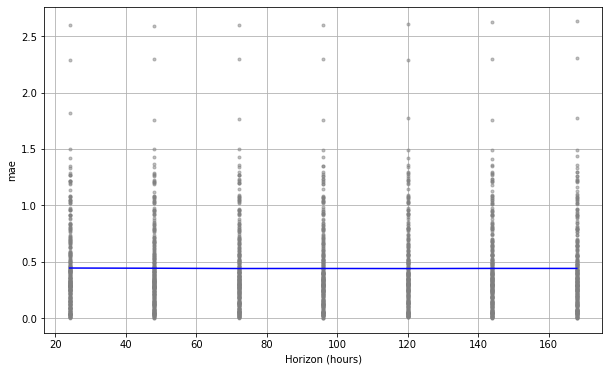

In [133]:
plot_cross_validation_metric(df_cv_flower, 'mae');

# Do Not Use Below

In [119]:
m_1216 = Prophet(daily_seasonality=True,growth='linear',holidays=holidays)
#
m_1216.fit(fb_df)

from fbprophet.diagnostics import cross_validation
df_cv_1216 = cross_validation(m_1216, initial='1216 days', period='1 days', horizon = '7 days')
df_cv_1216


INFO:fbprophet:Making 602 forecasts with cutoffs between 2018-03-03 00:00:00 and 2019-10-25 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-03-04,0.869882,0.119548,1.719501,1.609438,2018-03-03
1,2018-03-05,2.218576,1.424278,3.031650,2.197225,2018-03-03
2,2018-03-06,2.229323,1.439921,2.985870,2.397895,2018-03-03
3,2018-03-07,2.401422,1.583583,3.169781,2.079442,2018-03-03
4,2018-03-08,2.367359,1.545329,3.165837,2.302585,2018-03-03
...,...,...,...,...,...,...
4209,2019-10-28,2.005327,1.252262,2.802244,1.386294,2019-10-25
4210,2019-10-29,2.083445,1.249586,2.891866,1.386294,2019-10-25
4211,2019-10-30,2.221929,1.430170,2.986842,1.945910,2019-10-25
4212,2019-10-31,2.192909,1.450063,3.021376,1.945910,2019-10-25


In [148]:
df_p_1216 = performance_metrics(df_cv_1216)
df_p_1216

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,coverage
0,1 days,0.338577,0.581874,0.415934,0.870432
1,2 days,0.340104,0.583185,0.417128,0.868771
2,3 days,0.341914,0.584734,0.418352,0.867110
3,4 days,0.341760,0.584602,0.419254,0.867110
4,5 days,0.340422,0.583457,0.418158,0.868771
5,6 days,0.340844,0.583818,0.418788,0.868771
6,7 days,0.341638,0.584498,0.419605,0.868771


In [441]:
m_1520 = Prophet(daily_seasonality=True,growth='linear',holidays=holidays)
#
m_1520.fit(fb_df)

from fbprophet.diagnostics import cross_validation
df_cv_1520 = cross_validation(m_1216, initial='1520 days', period='1 days', horizon = '7 days')
df_cv_1520

INFO:fbprophet:Making 298 forecasts with cutoffs between 2019-01-01 00:00:00 and 2019-10-25 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-02,1.805307,0.990485,2.599998,0.000000,2019-01-01
1,2019-01-03,1.770072,0.984430,2.542539,0.000000,2019-01-01
2,2019-01-04,1.983687,1.188580,2.738438,1.609438,2019-01-01
3,2019-01-05,1.877595,1.105567,2.626596,1.945910,2019-01-01
4,2019-01-06,0.330764,-0.523240,1.058589,1.791759,2019-01-01
...,...,...,...,...,...,...
2081,2019-10-28,2.005327,1.235486,2.730612,1.386294,2019-10-25
2082,2019-10-29,2.083445,1.322703,2.874639,1.386294,2019-10-25
2083,2019-10-30,2.221929,1.446494,2.927062,1.945910,2019-10-25
2084,2019-10-31,2.192909,1.476145,2.894873,1.945910,2019-10-25


In [442]:
df_p_1520 = performance_metrics(df_cv_1520)
df_p_1520

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,coverage
0,1 days,0.345806,0.588053,0.414531,0.869128
1,2 days,0.338155,0.581511,0.411543,0.875839
2,3 days,0.329321,0.573865,0.407059,0.869128
3,4 days,0.329823,0.574302,0.407897,0.869128
4,5 days,0.329437,0.573966,0.408056,0.875839
5,6 days,0.322552,0.567936,0.404272,0.875839
6,7 days,0.323145,0.568458,0.404438,0.875839


In [ ]:

from sklearn.metrics import mean_absolute_error
# mae = np.expm1(mean_absolute_error(df_cv_rose['y'],df_cv_rose['yhat']))
# mae

In [ ]:
# np.log1p
# np.expm1

In [ ]:
prod_order201419['Price_Bin'].value_counts()

# Flask App Code

In [397]:
input_date = '2019-11-2'
dt = datetime.strptime(input_date, '%Y-%m-%d')

pred_window_min = fb_df['ds'].max()+pd.to_timedelta(1, unit='d')
dt_pred_window_min = datetime.strptime(str(pred_window_min.date()), '%Y-%m-%d')

pred_window_max = fb_df['ds'].max()+pd.to_timedelta(7, unit='d')
dt_pred_window_max = datetime.strptime(str(pred_window_max.date()), '%Y-%m-%d')


if fb_df.index[fb_df['ds'] == input_date].tolist():
    y = fb_df.loc[fb_df.ds == input_date, 'y']
    #print('This date has already passed. The actual number of orders on '+'{0}/{1}/{2:02}'.format(dt.month, dt.day, dt.year % 100)+' was: '+str(int(np.expm1(y))))
    print('This date has already passed. The actual number of orders on '+'{0}/{1}/{2:02}'.format(dt.month, dt.day, dt.year % 100)+' was: '+str(y))
elif pd.to_datetime(input_date) > (fb_df['ds'].max() +pd.to_timedelta(7, unit='d')):    
    print('This date is too far in the future. Cannot predict based on the currently available data. Please try another date between '+'{0}/{1}/{2:02}'.format(dt_pred_window_min.month, dt_pred_window_min.day, dt_pred_window_min.year % 100)+' and '+'{0}/{1}/{2:02}'.format(dt_pred_window_max.month, dt_pred_window_max.day, dt_pred_window_max.year % 100))
    

else:
    future_pred = pd.DataFrame(columns=['Date','future_yhat','future_yhat_lower','future_yhat_upper'])
#     future_pred['Date'] = 0
#     future_pred['future_yhat'] = 0
#     future_pred['future_yhat_lower'] = 0
#     future_pred['future_yhat_upper'] = 0
#     future_date = []
#     future_yhat = []
#     future_yhat_lower = []
#     future_yhat_upper = []
    fb_df = fb_df[['ds','y']]
    
    train_model = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,growth='linear')
    train_model.fit(fb_df.iloc[fb_df['ds'].idxmin():fb_df['ds'].idxmax()+1])
    future = train_model.make_future_dataframe(periods=7,include_history=False)
    forecast = train_model.predict(future)
    
    future_date = forecast.ds.tolist()
#     yhat_predictions = np.expm1(forecast.yhat).tolist()
#     yhat_lower_predictions = np.expm1(forecast.yhat_lower).tolist()
#     yhat_upper_predictions = np.expm1(forecast.yhat_upper).tolist()
    yhat_predictions = forecast.yhat.tolist()
    yhat_lower_predictions = forecast.yhat_lower.tolist()
    yhat_upper_predictions = forecast.yhat_upper.tolist()
    
    future_pred['Date'] = future_date
    future_pred['future_yhat'] = np.expm1(yhat_predictions)
    future_pred['future_yhat_lower'] = np.expm1(yhat_lower_predictions)
    future_pred['future_yhat_upper'] = np.expm1(yhat_upper_predictions)
#   
    future_pred['Predicted Orders'] = future_pred['future_yhat'].astype(int)
    future_pred['future_yhat_lower'] = future_pred['future_yhat_lower'].astype(int)
    future_pred['future_yhat_upper'] = future_pred['future_yhat_upper'].astype(int)
    future_pred['Day Name'] = future_pred['Date'].dt.day_name()
    future_pred['Prediction Date'] = future_pred['Day Name']+', '+future_pred['Date'].dt.strftime("%m/%d").astype(str)
    future_pred['Predicted Order Range'] = future_pred['future_yhat_lower'].map(str)+' - '+future_pred['future_yhat_upper'].map(str) 
    future_pred_final = future_pred[['Prediction Date','Predicted Orders']]
    print(future_pred_final.to_string(index=False))
    #print(future_pred_final.iloc[future_pred.index[future_pred['Date'] == input_date]].to_string(index=False))
    
#     future_date.append(forecast.ds)
#     future_yhat.append(yhat_predictions)
#     future_yhat_lower.append(yhat_lower_predictions)
#     future_yhat_upper.append(yhat_upper_predictions)
#     future_pred['Date'] = future_date
#     future_pred['future_yhat'] = yhat_predictions
#     future_pred['future_yhat_lower'] = future_yhat_upper
#     future_pred['future_yhat_lower'] = future_yhat_upper
#datetime(forecast.ds).weekday()
# future_pred


  Prediction Date  Predicted Orders
  Saturday, 11/02                 7
    Sunday, 11/03                 0
    Monday, 11/04                 5
   Tuesday, 11/05                 5
 Wednesday, 11/06                 6
  Thursday, 11/07                 6
    Friday, 11/08                 8


In [ ]:
fb_df['y'][index] if fb_df.index[fb_df['ds'] == input_date].tolist()

In [ ]:
forecast.ds

In [ ]:
fb_df.iloc[fb_df['ds'].idxmin():fb_df['ds'].idxmax()+1]

In [ ]:
input_date = '2019-11-1'
fb_df.index[fb_df['ds']==input_date].tolist()[0]

In [ ]:
fb_df.index[fb_df['ds']==datetime(input_date).date()-timedelta(1)

In [ ]:
future_pred

In [ ]:
naive_cv_365_list = []


Naive_365 = fb_df.copy()
Naive_365['naive_365_predictions'] = Naive_365['y'].shift(365)
Naive_365



In [ ]:
rolling_expected = fb_df.y.iloc[365:].tolist()
rolling_predictions = Naive_365.naive_365_predictions.iloc[365:].tolist()
mae_rolling = np.expm1(mean_absolute_error(rolling_expected, rolling_predictions))
mae_rolling 

In [ ]:
Naive_365[Naive_365['naive_365_predictions'].isnull()]

In [ ]:
#index of specific input date: fb_df.iloc[fb_df.index[fb_df['ds']==pd.to_datetime(input_date)-timedelta(1)].tolist()[0]:fb_df['ds'].idxmax()]